# Анализ маркетинговых расходов интернет-магазина


подготовил: [Вова Сизов](mailto:vladimirsizov@yandex.ru)

<hr>

Отдел маркетинга обратился к аналитикам с просьбой проанализировать:
- чувствительные показатели аудитории
- оценить качество покупателей
- расходы отдела маркетинга
- подготовить обоснование для оптимизации работы с каналами привлечения.  

Мы работаем с приложением в котором пользователи совершают внутренние покупки.  
Имеются данные за период с 2019-01-01 по 2019-30-09   
Прежде чем совершить покупки пользователи знакомятся с товарами. 

Задачи посчитать и проанализировать:

Аудитория:
- размер аудитории, MAU, WAU, DAU
- качество взаимодействия, количество сессий, просмотров на сессию, фактор залипания
- RR показатель удержания пользователей

Продажи:
- Revenue
- количество покупателей, количество покупок, покупок на пользователя
- средний чек
- CR1 конверсия в покупку, время первой покупки после установки 
- ARPPU средний доход на покупателя 

Источники трафика и маркетинг:
- расходы на рекламу всего и по источникам
- стоимость привлечения покупателя по источникам
- LTV прибыль которую приносит клиент
- ROMI коэффициент возврата маркетинговых инвестиций


<hr>

In [1]:
import pandas as pd
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize': (12, 6.75)})

## 0. EDA разведочный анализ данных

### Данные предоставленные для работы:
devices - склейка устройств и User ID   
installs данные регистрации в системе, и источниках трафика  
events - данные об активности просмотра товаров  
checks - данные о покупках и их стоимости  

In [2]:
devices = pd.read_csv('devices.csv', dtype={'DeviceID': 'uint64', 'UserID': 'uint64'})
installs = pd.read_csv('installs.csv', parse_dates=['InstallationDate'])
events = pd.read_csv('events.csv', parse_dates=['EventDate'])
checks = pd.read_csv('checks.csv', parse_dates=['BuyDate'])

Для каждой таблицы:
- проверим содержимое  
- информацию о типах и количестве записей  
- наличие пропусков  
- наличие полных дубликатов  

In [3]:
# обзор данных
def data_check(data):
    display(data.head())
    display(data.info())
    null_values = data.isnull().sum().sum()
    if null_values == 0:
        print('пропуски:', data.isnull().sum().sum())
    else:
        print('пропуски:', data.isnull().sum())
    print('дубликаты:', data.duplicated().sum())

<hr>

### Склейка устройств и User ID

Особенность сервиса заключается в том, что для просмотра товаров не нужна авторизация.  
До момента авторизации про пользователя известен только его DeviceID — идентификатор устройства.  
При этом для совершения покупки логин обязателен.  
На моменте авторизации пользователю присваивается UserID, и тогда мы уже знаем два его идентификатора: DeviceID (устройство) и UserID (логин).  
Так как на этапах установки приложения и просмотра каталога пользователь еще может быть не авторизован, там мы сохраняем только DeviceID.  
Но так как покупки нельзя совершить без авторизации, то покупки сохраняются только с UserID.  
Для того чтобы просмотры и установки можно было объединить с покупками, нам нужна таблица соответствия DeviceID к UserID, то есть таблица devices:

DeviceID — идентификатор устройства  
UserID — идентификатор пользователя

In [4]:
data_check(devices)

,DeviceID,UserID
0,2061461442082440457,5890312570997226086
1,2061502319468333809,7597630269297929747
2,2061549705656161924,4684956878445305718
3,2061590374665983626,4564106340145658170
4,2061630421844171981,16634945760702342388


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470332 entries, 0 to 470331
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   DeviceID  470332 non-null  uint64
 1   UserID    470332 non-null  uint64
dtypes: uint64(2)
memory usage: 7.2 MB


None

пропуски: 0
дубликаты: 0


<hr>

### Данные о регистрации в системе

DeviceID — идентификатор устройства  
InstallationDate — дата регистрации  
InstallCost — цена привлечения клиента  
Platform — платформа  
Source — источник трафика  

In [5]:
data_check(installs)

,DeviceID,InstallationDate,InstallCost,Platform,Source
0,2061461442082440457,2019-02-19,1.33,android,Source_14
1,2061549705656161924,2019-02-18,0.00,android,Source_27
2,2061590374665983626,2019-01-24,0.00,iOS,Source_27
3,2061630421844171981,2019-09-03,0.00,android,Source_27
4,2061656490978911882,2019-04-22,1.12,android,Source_14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286154 entries, 0 to 286153
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DeviceID          286154 non-null  uint64        
 1   InstallationDate  286154 non-null  datetime64[ns]
 2   InstallCost       286154 non-null  float64       
 3   Platform          286154 non-null  object        
 4   Source            286154 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2), uint64(1)
memory usage: 10.9+ MB


None

пропуски: 0
дубликаты: 0


<hr>

### Данные об активности просмотра товаров

DeviceID — идентификатор устройства  
AppPlatform — платформа  
EventDate — дата события  
events — количество просмотров всех товаров за этот день у этого DeviceID.  

In [6]:
data_check(events)

,DeviceID,AppPlatform,events,EventDate
0,10116097407821560691,android,51,2019-01-04
1,10116141036402249962,android,1,2019-01-04
2,10116163208905002180,android,0,2019-01-05
3,10116163208905002180,android,53,2019-01-07
4,10116163208905002180,android,8,2019-01-09


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8550265 entries, 0 to 8550264
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   DeviceID     uint64        
 1   AppPlatform  object        
 2   events       int64         
 3   EventDate    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1), uint64(1)
memory usage: 260.9+ MB


None

пропуски: 0
дубликаты: 0


<hr>

### Данные о покупках  

UserID — идентификатор пользователя   
Rub — суммарный чек пользователя  
BuyDate — дата  

In [7]:
data_check(checks)

,UserID,Rub,BuyDate
0,5890312570997226086,0,2019-02-28
1,5890312570997226086,11,2019-02-25
2,5890312570997226086,0,2019-02-23
3,5890312570997226086,3,2019-02-22
4,5890312570997226086,1,2019-02-21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145336 entries, 0 to 145335
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   UserID   145336 non-null  uint64        
 1   Rub      145336 non-null  int64         
 2   BuyDate  145336 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), uint64(1)
memory usage: 3.3 MB


None

пропуски: 0
дубликаты: 0


<hr>

## 1. Аудитория

### Размер аудитории

Магазин продаёт товары, перед покупкой пользователи желают ознакомится с товарами.  

Важным показателем будет количество просмотров товаров.  

Размер аудитории, как часто пользуются сервисом:  
MAU (month active users) месячная аудитория  
WAU (week active users) недельная аудитория  
DAU (daily active users) дневная аудитория 

Частота посещения, фактор залипания.

Пользовательские метрики (в среднем, месяц, неделю, день):  
Количество просмотров товаров  
Количество сессий  

In [8]:
# добавим несколько колонок
events['month'] = events['EventDate'].dt.month
events['week'] = events['EventDate'].dt.isocalendar().week
events['day'] = events['EventDate'].dt.day
events.head()

,DeviceID,AppPlatform,events,EventDate,month,week,day
0,10116097407821560691,android,51,2019-01-04,1,1,4
1,10116141036402249962,android,1,2019-01-04,1,1,4
2,10116163208905002180,android,0,2019-01-05,1,1,5
3,10116163208905002180,android,53,2019-01-07,1,2,7
4,10116163208905002180,android,8,2019-01-09,1,2,9


In [9]:
# посчитаем MAU, WAU, DAU
mau = events.groupby('month')['DeviceID'].nunique().mean().astype(int)
wau = events.groupby(['month', 'week'])['DeviceID'].nunique().mean().astype(int)
dau = events.groupby(['month', 'day'])['DeviceID'].nunique().mean().astype(int)
print(mau, 'MAU месячная аудитория\n', wau, 'WAU недельная аудитория\n', dau, 'DAU дневная аудитория')

183327 MAU месячная аудитория
 90643 WAU недельная аудитория
 31319 DAU дневная аудитория


In [10]:
# посчитаем sticky_factor
sticky_factor = dau / mau
print(round(sticky_factor, 2), 'sticky_factor')

0.17 sticky_factor


In [11]:
# просмотров на пользователя, сессий(дней) на пользователя, распределение просмотров, распределение сессий(дней): (за период)
def get_views_days(metric):
    if metric == 'day':
        views = events.groupby([metric, 'month', 'DeviceID']).agg({'events': ['sum', 'count']}).reset_index()
        views.columns = [metric, 'month', 'DeviceID', 'views', 'session']
        views['views_sess'] = views['views'] / views['session']
        views_days = views.groupby(metric).agg({'views': 'mean', 'session': 'mean'}).reset_index()
        return [views_days.views.mean(), views_days.session.mean(), views_days, views]
    else:
        views = events.groupby([metric, 'DeviceID']).agg({'events': ['sum', 'count']}).reset_index()
        views.columns = [metric, 'DeviceID', 'views', 'session']
        views['views_sess'] = views['views'] / views['session']
        views_days = views.groupby(metric).agg({'views': 'mean', 'session': 'mean'}).reset_index()
        return [views_days.views.mean(), views_days.session.mean(), views_days, views]

In [12]:
data_month = get_views_days('month')
views_month = data_month[0]
sessions_month = data_month[1]
means_by_month = data_month[2]
distr_month = data_month[3]
print(' В месяц на пользователя:\n', round(views_month, 2), 'просмотров\n', round(sessions_month, 2), 'сессий')

 В месяц на пользователя:
 129.4 просмотров
 5.18 сессий


In [13]:
data_week = get_views_days('week')
views_week = data_week[0]
sessions_week = data_week[1]
means_by_week = data_week[2]
distr_week = data_week[3]
print(' В неделю на пользователя:\n', round(views_week, 2), 'просмотров\n', round(sessions_week, 2), 'сессий')

 В неделю на пользователя:
 53.44 просмотров
 2.14 сессий


In [14]:
data_day = get_views_days('day')
views_day = data_day[0]
sessions_day = data_day[1]
means_by_day = data_day[2]
distr_day = data_day[3]
print(' В день на активного пользователя:\n', round(views_day, 2), 'просмотров\n', round(sessions_day, 2), 'сессий')

 В день на активного пользователя:
 24.97 просмотров
 1.0 сессий


### Резюме

Размеры аудитории:  
183327 MAU месячная аудитория  
90643 WAU недельная аудитория  
31319 DAU дневная аудитория  

Просмотров товаров на уникального пользователя:  
129.4 в месяц  
53.44 в неделю  
24.97 в день (у активного пользователя)  

Количество сессий у уникального пользователя:  
5.18 в месяц  
2.14 сессий  
1.0 сессий (у активного пользователя)  

Фактор залипания:  
0.17 sticky_factor

<hr>

### Пользовательская активность и качество взаимодействия

Посмотрим сколько сессий и просмотров товаров в среднем приходится на пользователя 

Проверим качество источников

In [15]:
# отрисовка графика распределения
def show_distrib(distrib, name, xlabel, ylabel):
    bins = int(distrib.max() - distrib.min())
    bins = 100 if bins>100 else bins
    ymax = distrib[distrib == distrib.mode()[0]].shape[0]
    plt.title(name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.vlines(np.median(distrib), ymin=0, ymax=ymax, linestyle='--')
    distrib.hist(bins=bins);

In [16]:
view_99 = events.events.quantile([.999]).values[0]
view_max = events.events.max()
view_mean = round(events.events.mean())
view_median = round(events.events.median())

print('Так как есть значительные выбросы в распределении частоты просмотров (максю знач.', view_max, ', а 99,9% квантиль', \
      view_99, ')\nДля показателя среднего количества просмотров на сессию вместо среднего', view_mean, 'мы выберем медиану', \
      view_median)

Так как есть значительные выбросы в распределении частоты просмотров (максю знач. 10324 , а 99,9% квантиль 393.0 )
Для показателя среднего количества просмотров на сессию вместо среднего 25 мы выберем медиану 11


In [17]:
# количество всех просмотров у всех пользователей
all_view = events.events.sum()

# распределение количества сессий
distr_session = events.groupby('DeviceID').agg({'events': 'count'}).events

# среднее количество сессий на пользователя
median_session = round(distr_session).median()

# среднее количество просмотров на сессию
view_session = all_view / distr_session.sum()

в медиане на пользователя приходится 7 сессий


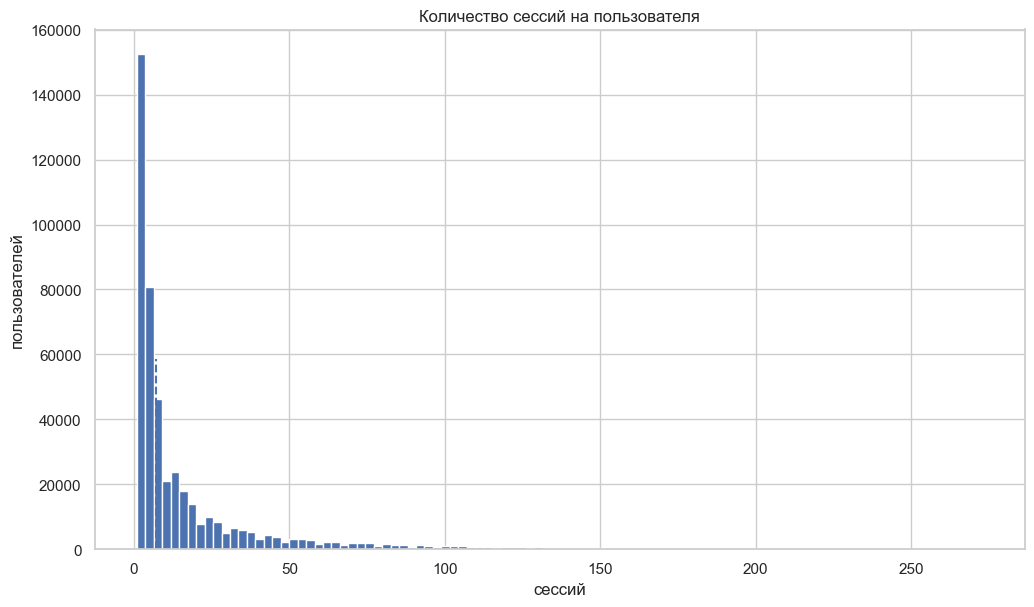

In [18]:
print('в медиане на пользователя приходится', round(median_session), 'сессий')
show_distrib(distr_session, 'Количество сессий на пользователя', 'сессий', 'пользователей')

в медиане на сессию 11 просмотров


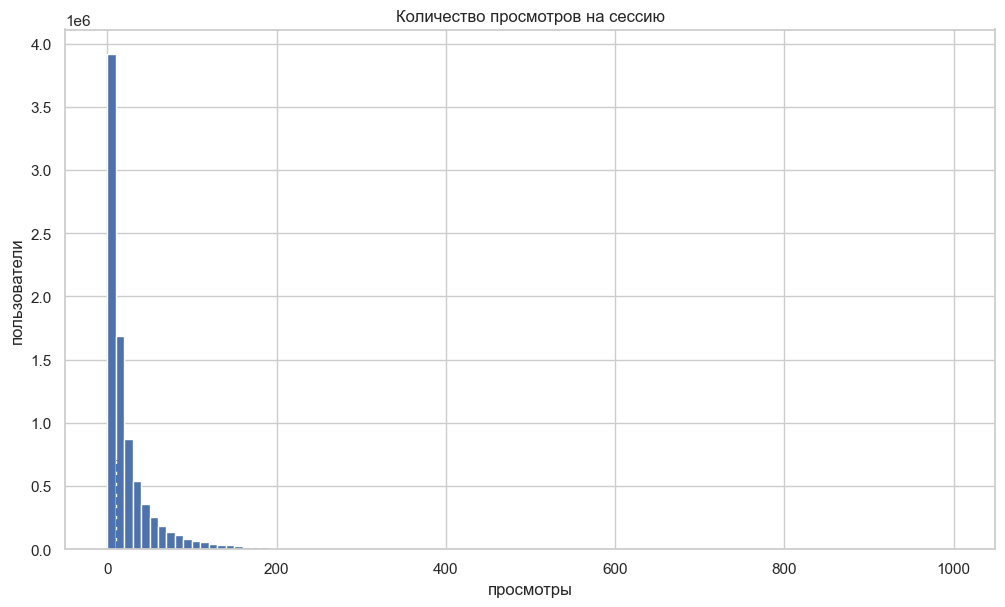

In [19]:
print('в медиане на сессию', view_median, 'просмотров')
show_distrib(events[events.events < 1000].events, 'Количество просмотров на сессию', 'просмотры', 'пользователи')

In [20]:
# уникальные источники трафика
sources = sorted(installs.Source.unique().tolist())

In [21]:
# список подозрительных DeviceID с аномалии просмотров
suspicious_device_id = events[events.events > view_99].DeviceID.to_frame()
suspicius_source = suspicious_device_id.merge(installs, on='DeviceID')
del suspicius_source['InstallCost']
print(len(suspicius_source), 'подозрительных DeviceID')
suspicius_source.head()

868 подозрительных DeviceID


,DeviceID,InstallationDate,Platform,Source
0,14474178380792146679,2019-01-06,iOS,Source_27
1,3691551204902310141,2019-01-11,android,Source_27
2,3777383019355969932,2019-01-06,android,Source_9
3,3801097366558106529,2019-01-02,android,Source_27
4,3865227446677756791,2019-01-13,android,Source_9


In [22]:
# количество пользователей по источникам
def show_displot(data, name, xlabel, ylabel, ticks):
    sns.displot(data, y='Source', aspect=16/7)
    plt.title(name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yticks(sources);

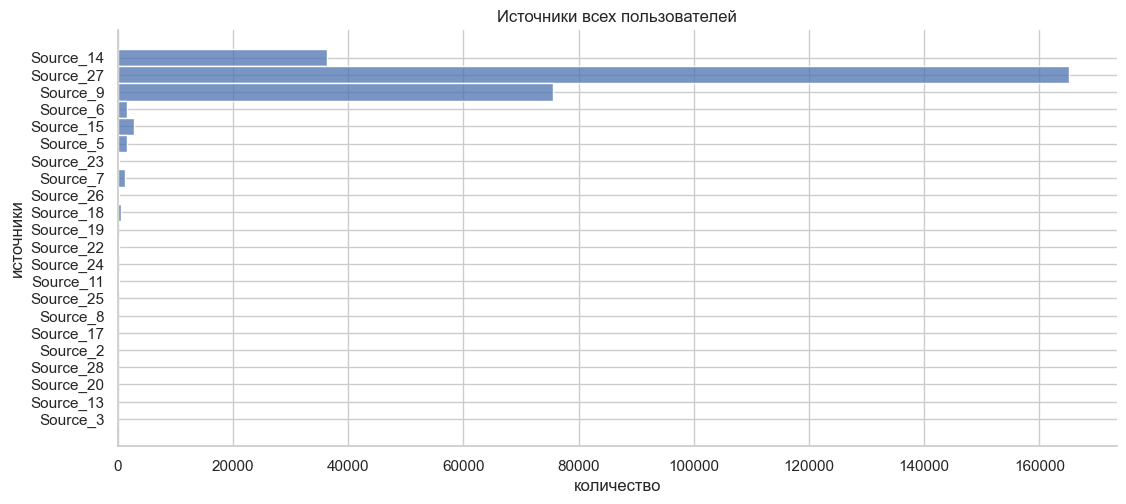

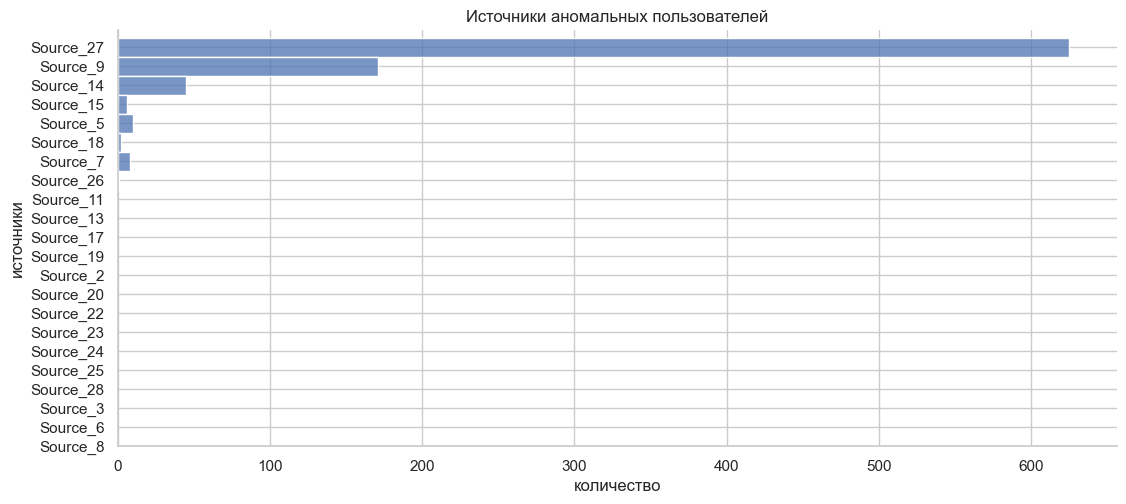

In [23]:
show_displot(installs, 'Источники всех пользователей', 'количество', 'источники', sources)
show_displot(suspicius_source, 'Источники аномальных пользователей', 'количество', 'источники', sources)

In [24]:
# список подозрительных источников
suspicius_sources = suspicius_source.Source.unique().tolist()

# соберём относительные значения
norm_suspic = suspicius_source.Source.value_counts(normalize=True).to_frame()
norm_suspic.columns=['suspicius']
norm_install = installs[installs.Source.isin(suspicius_sources)].Source.value_counts(normalize=True).to_frame()
norm_install.columns=['installs']

# объединим данные из источников
compare_sources = pd.concat([norm_install.T, norm_suspic.T]).T

# сравним и отсортируем
compare_sources['difference'] = compare_sources.suspicius / compare_sources.installs
compare_sources.sort_values('difference', ascending=False).head()

,installs,suspicius,difference
Source_5,0.005754,0.011521,2.002067
Source_7,0.004679,0.009217,1.969780
Source_27,0.582452,0.720046,1.236233
Source_26,0.000980,0.001152,1.175314
Source_18,0.002140,0.002304,1.076565


In [25]:
# отберём самые значительные
increase = round(compare_sources[compare_sources.difference > compare_sources.difference.mean()].difference.mean(), 1)
list_suspect_sources = compare_sources[compare_sources.difference > compare_sources.difference.mean()].index.tolist()
print('В', increase, 'раза чаще подозрительные приходят из источников:\n', list_suspect_sources)

В 1.6 раза чаще подозрительные приходят из источников:
 ['Source_27', 'Source_5', 'Source_7', 'Source_26']


### Резюме

в медиане на пользователя приходится 7 сессий  
в медиане на сессию 11 просмотров  

при этом наиболее частое количество просмотров за сессию 0  
Такое поведение пользователей может быть вызвано несколькими причинами:  
- непонятный интерфейс  
- ользователь не смог быстро найти нужное и потерял интерес (недостаток контента).  
- пользователь открыл сайт случайно, потому что искал что то с похожим названием.  

У 0,1% пользователей количество просмотров больше 393, и достигает максимума 10324 просмотра.  
Это может быть связано с действиями парсеров или обходом роботов поисковых систем.  
В 2 раза чаще подозрительные приходят из источников 'Source_5', 'Source_7'  
868 подозрительных DeviceID  

<hr>

### Retention Rate
RR (retention rate) показатель удержания пользователей 

In [26]:
# определяем первую активность пользователей
first_initialize = events[['DeviceID', 'EventDate']].groupby('DeviceID').agg({'EventDate': 'min'}).reset_index()
#first_initialize.head()

In [27]:
# обьединяем установки и первую активность
data_cohort = installs[['DeviceID', 'InstallationDate']].merge(first_initialize, on='DeviceID')
#data_cohort.head()

In [28]:
# так как она может быть раньше установки, мы также её будем учитывать в качестве определения когорт
print('', data_cohort[data_cohort.InstallationDate > data_cohort.EventDate].shape[0], \
      'пользователей пользовались сервисом до авторизации\n', \
      data_cohort[data_cohort.InstallationDate < data_cohort.EventDate].shape[0], \
      'пользователей использовали сервис только после дня авторизации')

 298 пользователей пользовались сервисом до авторизации
 3596 пользователей использовали сервис только после дня авторизации


In [29]:
# определяем минимальное значение и определяем его в качестве когорты
data_cohort['name_cohort'] = data_cohort.apply(lambda x: min(x['InstallationDate'], x['EventDate']), axis = 1)
data_cohort['cohort'] = data_cohort['name_cohort'].dt.month
#data_cohort.head()

In [30]:
# определяем когорты для DeviceID
cohort = data_cohort[['DeviceID', 'cohort']]
#cohort.head()

In [31]:
# подберём понятные имена когорт
names_cohort = data_cohort[['cohort', 'name_cohort']].groupby('cohort').agg({'name_cohort': 'min'}).reset_index()
names_cohort['name_cohort'] = names_cohort.name_cohort.dt.strftime('%Y-%m')
#names_cohort.head()

In [32]:
# считаем размеры когорт
cohort_size = cohort.groupby('cohort').agg({'DeviceID': 'count'}) \
    .rename(columns={'DeviceID': 'size_cohort'}).reset_index()
#cohort_size.head()

In [33]:
# определяем как показатель удержания - инициализацию пользователя, при активности > 0
data_retention = events[events.events != 0][['DeviceID', 'month']].rename(columns={'month': 'initialize'})
#data_retention.head()

In [34]:
# подписываем к каждой инициализации её когорту
retention = data_retention.merge(cohort, on='DeviceID')
retention = retention.drop_duplicates()

# считаем разницу между когортой и инициализацией
retention['month'] = retention['initialize'] - retention['cohort']
#retention.head()

In [35]:
# считаем количество пользователей для каждой когорты в каждый месяц
retention = retention.groupby(['cohort', 'month']).agg({'DeviceID': 'count'}) \
.rename(columns={'DeviceID': 'users'}).reset_index()
#retention.head()

In [36]:
# добавим данные о размерах когорт
retention = retention.merge(cohort_size, on='cohort')
#retention.head()

In [37]:
#посчитаем Retention Rate
retention['RR'] = round((retention.users / retention.size_cohort), 2)
#retention.head()

In [38]:
# подставим понятные имена когорт
retention = retention.merge(names_cohort, on='cohort').drop(columns=['cohort']) \
    .rename(columns={'name_cohort': 'cohort'})
retention.head()

,month,users,size_cohort,RR,cohort
0,0,10323,10586,0.98,2019-01
1,1,6123,10586,0.58,2019-01
2,2,4590,10586,0.43,2019-01
3,3,3823,10586,0.36,2019-01
4,4,3392,10586,0.32,2019-01


In [39]:
# построение графика когорт
def get_cohort_chart(data, index, columns, values, title, fmt):
    chart = data.pivot_table(index=index, columns=columns, values=values, aggfunc='mean') 
    plt.figure(figsize=(12, 6.75))
    plt.title(title)
    sns.heatmap(chart, annot=True, fmt=fmt, cmap='Blues')
    plt.yticks(rotation = 0);

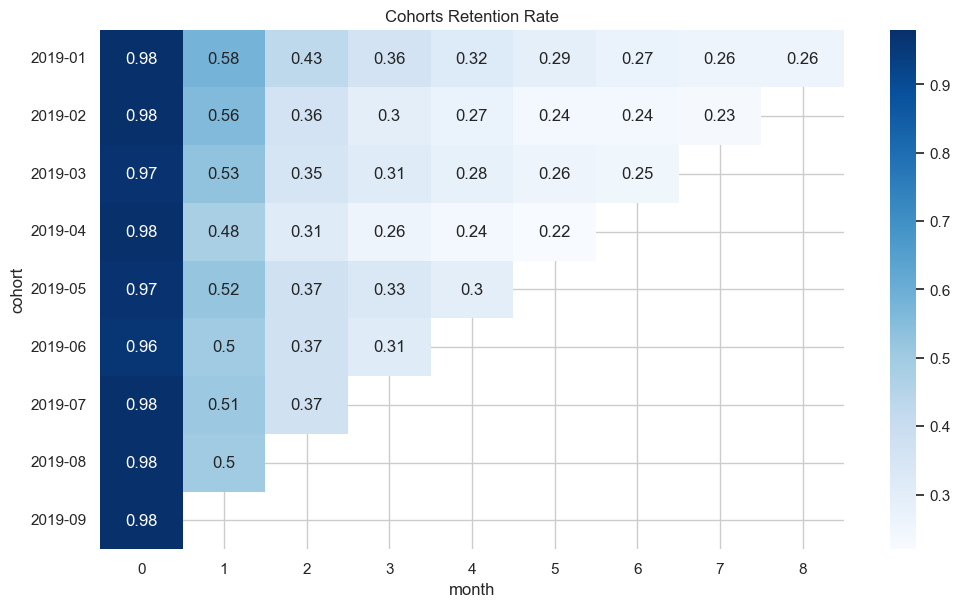

In [40]:
# построим RR
get_cohort_chart(retention, 'cohort', 'month', 'RR', 'Cohorts Retention Rate', '')

In [41]:
rr = retention.groupby('month').agg({'RR': 'mean'})
rr.T

month,0,1,2,3,4,5,6,7,8
RR,0.975556,0.5225,0.365714,0.311667,0.282,0.2525,0.253333,0.245,0.26


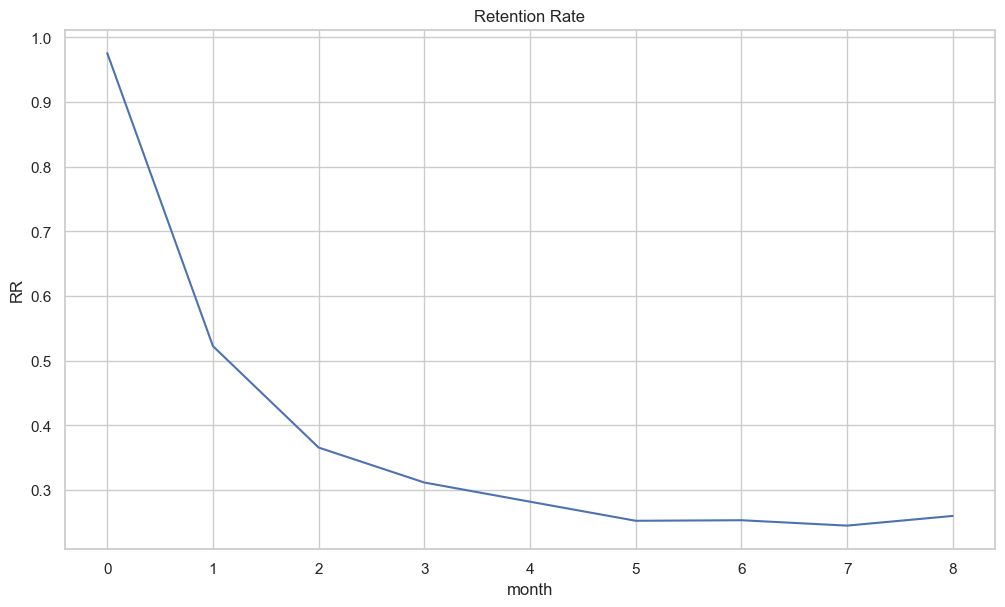

In [42]:
# построим график RR
plt.title('Retention Rate')
sns.lineplot(data=rr, x='month', y='RR');

### Резюме

298 пользователей пользовались сервисом до авторизации  
3596 пользователей использовали сервис только после дня авторизации

RR показатель удержания покупателей:  
52% в первый месяц  
25% остаются после 5 месяца, что в целом хороший показатель 

<hr>

## Продажи

### Основные показатели

Изменение по месяцам: Revenue, рекламных расходов и доли рекламных расходов в прибыли  

Количество пользователей и покупателей, а также конверсия в покупку

Количество покупок на покупателя в среднем  

In [43]:
# прибыль по месяцам
revenue = checks.copy()
revenue['month'] = revenue['BuyDate'].dt.month
revenue = revenue.groupby('month').agg({'Rub': 'sum'}).reset_index().rename(columns={'Rub':'revenue'})

advertising = installs.copy()
advertising['month'] = advertising['InstallationDate'].dt.month
advertising = advertising.groupby('month').agg({'InstallCost': 'sum'}).reset_index() \
    .rename(columns={'InstallCost':'cost'})

advertising_revenue = advertising.merge(revenue, on='month')
advertising_revenue['percent_cost'] = round(advertising_revenue['cost'] / advertising_revenue['revenue'], 2)

In [44]:
mar_1 = advertising_revenue.revenue[0]
mar_9 = advertising_revenue.revenue[8]
mar = round(mar_9 * 100 / mar_1)
ad_1 = round(advertising_revenue.cost[0])
ad_9 = round(advertising_revenue.cost[8])
ad = round(100 - ad_9 * 100 / ad_1)
per_1 = advertising_revenue.percent_cost[0]
per_9 = advertising_revenue.percent_cost[8]
per = round(100 - per_9 * 100 / per_1)
print('за 9 месяцев:\nприбыль увеличилась на ', mar, '%,  с', mar_1, 'до', mar_9, 'в месяц')
print('рекламные расходы снизились на ', ad, '%,  с', ad_1, 'до', ad_9, 'в месяц')
print('доля рекламы в прибыли снизились на ', per, '%,  с', per_1, 'до', per_9, 'в месяц')

за 9 месяцев:
прибыль увеличилась на  412 %,  с 69006 до 284136 в месяц
рекламные расходы снизились на  35 %,  с 24157 до 15697 в месяц
доля рекламы в прибыли снизились на  83 %,  с 0.35 до 0.06 в месяц


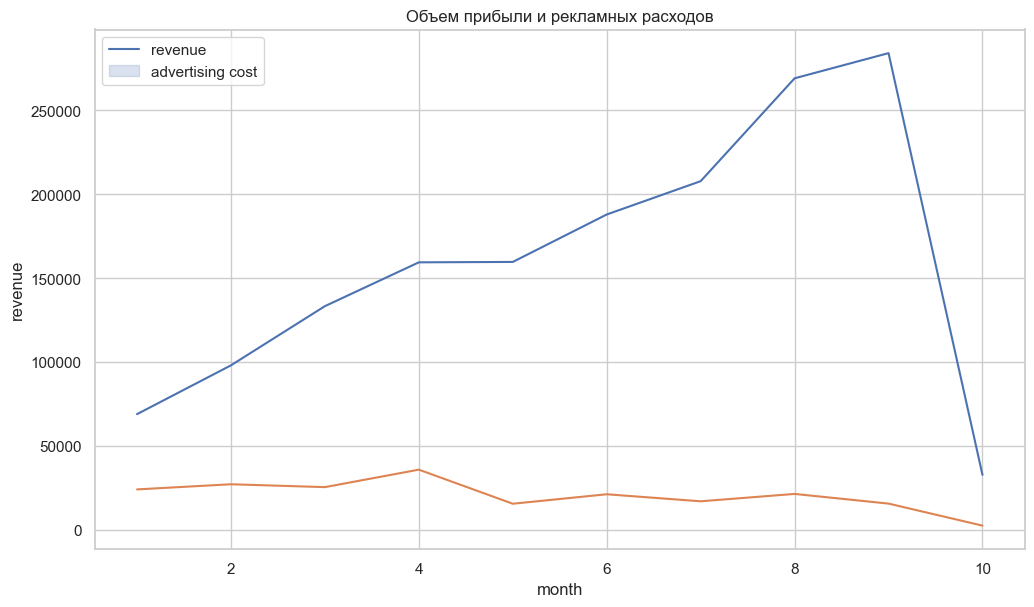

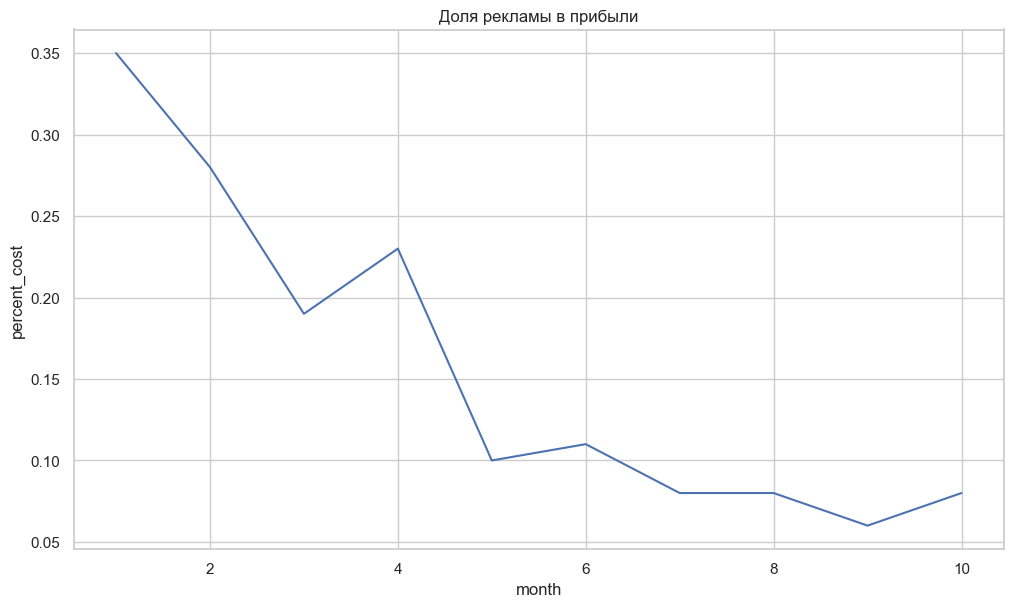

In [45]:
sns.lineplot(data=advertising_revenue, x='month', y='revenue')
sns.lineplot(data=advertising_revenue, x='month', y='cost')
plt.title('Объем прибыли и рекламных расходов');
plt.legend(['revenue', 'advertising cost'])
plt.show()
sns.lineplot(data=advertising_revenue, x='month', y='percent_cost')
plt.title('Доля рекламы в прибыли');

In [46]:
users = devices.DeviceID.nunique()
customers = checks[checks.Rub > 0].UserID.nunique()
purchases = checks[checks.Rub > 0].shape[0]

print(users, 'уникальных пользователей')
print(customers, 'уникальных покупателей')
print(round(purchases / customers, 1), 'покупок на покупателя в среднем')
print(round(customers / users * 100),  'CR1 конверсия в покупку')

470332 уникальных пользователей
18771 уникальных покупателей
6.4 покупок на покупателя в среднем
4 CR1 конверсия в покупку


In [47]:
# первая покупка
first_buy = checks[checks.Rub > 0].groupby('UserID').agg({'BuyDate': 'min'}).reset_index().merge(devices, on='UserID')
#first_buy.head()

In [48]:
#
installs_buy = installs.merge(first_buy, on='DeviceID')
installs_buy['Days'] = (installs_buy['BuyDate'] - installs_buy['InstallationDate']).dt.days
#installs_buy.head()

50% покупок совершаются в первые 2 дня с момента регистрации


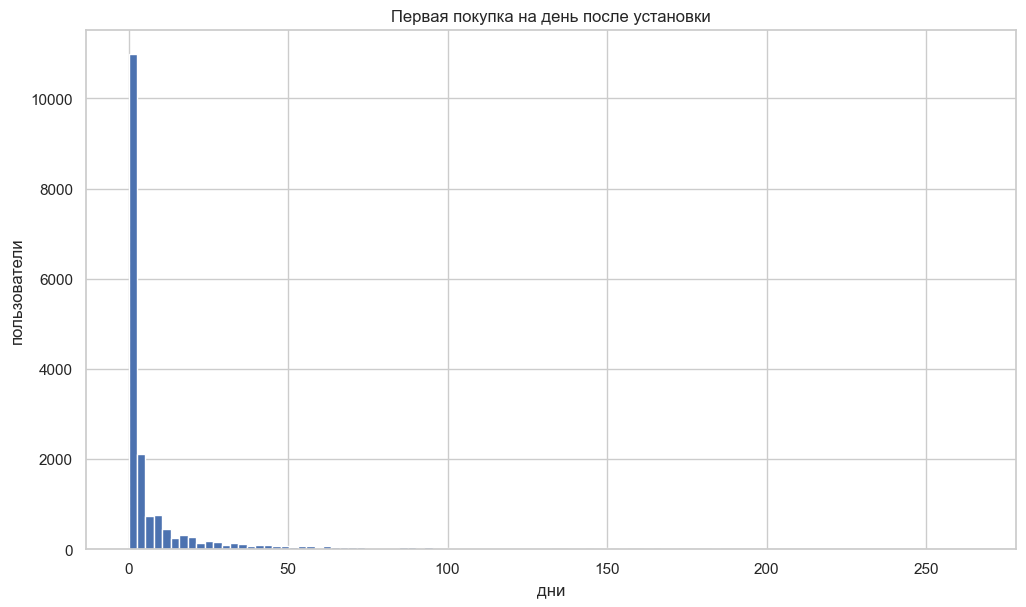

In [49]:
print('50% покупок совершаются в первые', round(installs_buy['Days'].median() + 1), 'дня с момента регистрации')
show_distrib(installs_buy.Days, 'Первая покупка на день после установки', 'дни', 'пользователи')

#### Вывод

466562 пользователей  
18771 покупателей  

6.4 покупок на покупателя в среднем  
0.04 CR1 конверсия пользователя в покупку 

50% покупок совершаются в первые 2 дня с момента регистрации

Наблюдения 9-ти месяцев:  

Прибыль увеличилась на 412%, с 69006 до 284136 в месяц. Это очень хороший показатель, сообщающий о высокой лояльности, доверию пользователей и возрастающем вовлечении, как показано (ниже) увеличением среднего чека с возрастом когорты.

Рекламные расходы снизились на 35%, с 24157 до 15697 в месяц.  
Доля рекламы в прибыли снизились на  83%, с 0.35 до 0.06 в месяц. 
Как показывают исследования (ниже) размеры когорт уменьшаются примерно в той же пропорции что и рекламные расходы (примерно на 30%), что в перспективе приводит к уменьшениию размера аудитории сервиса в связи с постепенным оттоком.

### Рекомнндации
Повысить размер рекламных бюджетов для сохранения размера аудитории до уровня первого месяца.

### Средний чек по когортам

Размер среднего чека

Когортный анализ, динамика:  
Средний чек  
Размер когорты  
Прибыль  

In [50]:
# присваиваем когорты для DeviceId
data_cohort = installs[['DeviceID', 'InstallationDate']].rename(columns={'InstallationDate': 'name_cohort'})
data_cohort['cohort'] = data_cohort['name_cohort'].dt.month
#data_cohort.head()

In [51]:
# определяем когорты для DeviceID
cohort = data_cohort[['DeviceID', 'cohort']]
#cohort.head()

In [52]:
# подберём понятные имена когорт
names_cohort = data_cohort[['cohort', 'name_cohort']].groupby('cohort').agg({'name_cohort': 'min'}).reset_index()
names_cohort['name_cohort'] = names_cohort.name_cohort.dt.strftime('%Y-%m')
#names_cohort.head()

In [53]:
# присваиваем DeviceID покупкам, и отбираем только платные, приваиваем когорты
checks_devices = checks[checks.Rub > 0].merge(devices, on='UserID')[['DeviceID', 'BuyDate', 'Rub']]\
    .merge(cohort, on='DeviceID')
#checks_devices.head()

In [54]:
# добавляем периоды к когортам
checks_devices['month'] = checks_devices['BuyDate'].dt.month - checks_devices.cohort
#checks_devices.head()

In [55]:
checks_devices_group = checks_devices.groupby(['cohort', 'month']) \
    .agg({'Rub': lambda x: round(x.mean(), 2)}).reset_index()
#checks_devices.head()

In [56]:
# подставим понятные имена когорт
avg_checks = checks_devices_group.merge(names_cohort, on='cohort').drop(columns=['cohort']) \
    .rename(columns={'name_cohort': 'cohort', 'Rub': 'AvgCheck'})
avg_checks.head()

,month,AvgCheck,cohort
0,0,12.44,2019-01
1,1,12.00,2019-01
2,2,12.39,2019-01
3,3,12.42,2019-01
4,4,11.34,2019-01


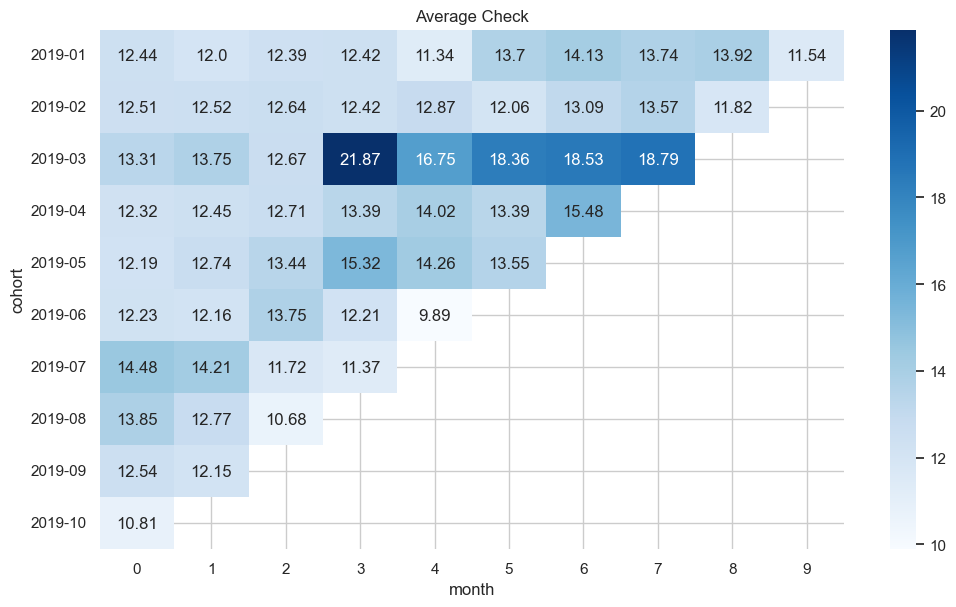

In [57]:
# посмотрим изменение среднего чека по когортам
get_cohort_chart(avg_checks, 'cohort', 'month', 'AvgCheck', 'Average Check', '')

In [58]:
result = avg_checks[['cohort', 'month', 'AvgCheck']] \
    .pivot_table(index='cohort', columns='month', values='AvgCheck', aggfunc='mean') 
result.head()

month,0,1,2,3,4,5,6,7,8,9
cohort,,,,,,,,,,
2019-01,12.44,12.00,12.39,12.42,11.34,13.70,14.13,13.74,13.92,11.54
2019-02,12.51,12.52,12.64,12.42,12.87,12.06,13.09,13.57,11.82,NaN
2019-03,13.31,13.75,12.67,21.87,16.75,18.36,18.53,18.79,NaN,NaN
2019-04,12.32,12.45,12.71,13.39,14.02,13.39,15.48,NaN,NaN,NaN
2019-05,12.19,12.74,13.44,15.32,14.26,13.55,NaN,NaN,NaN,NaN


In [59]:
# диапазон среднего чека
min_ = round(result.mean(axis=1).quantile(0.05), 1)
max_ = round(result.mean(axis=1).quantile(0.95), 1)
mp = 100 - round(min_ * 100 / np.mean([min_, max_]))

print('90% чеков в когортах колеблятся в значениях между', min_,'и', max_, 'в диапазоне  +/-', mp, '%')

90% чеков в когортах колеблятся в значениях между 11.4 и 15.3 в диапазоне  +/- 15 %


In [60]:
# средний чек по когортам
avg_check_cohort = result.mean(axis=1).to_frame()
avg_check_cohort.columns = ['values']
avg_check_cohort.T

cohort,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
values,12.762,12.611111,16.75375,13.394286,13.583333,12.048,12.945,12.433333,12.345,10.81


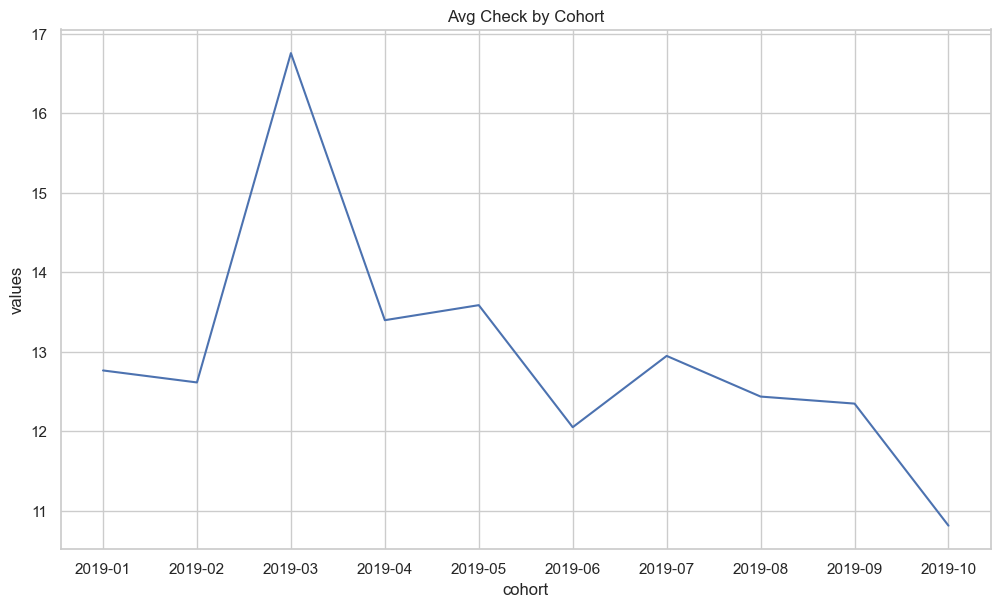

In [61]:
# средний чек по когортам
sns.lineplot(data=avg_check_cohort, x='cohort', y='values')
plt.title('Avg Check by Cohort');

In [62]:
# средний чек по месяцам
avg_check = result.mean().to_frame()
avg_check.columns = ['AvgCheck']
avg_check.T

month,0,1,2,3,4,5,6,7,8,9
AvgCheck,12.668,12.75,12.5,14.142857,13.188333,14.212,15.3075,15.366667,12.87,11.54


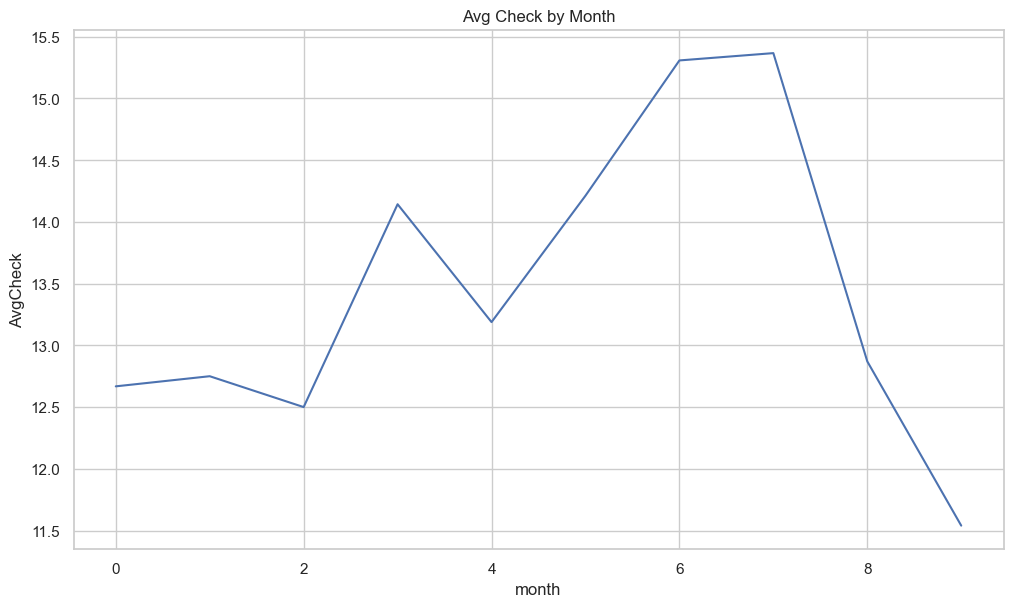

In [63]:
# средний чек по месяцам
sns.lineplot(data=avg_check, x='month', y='AvgCheck')
plt.title('Avg Check by Month');

In [64]:
month_0 = avg_check.iloc[[0]].values[0][0]
month_7 = avg_check.iloc[[7]].values[0][0]
month_9 = avg_check.iloc[[9]].values[0][0]
print(round(month_7 * 100 / month_0 - 100), '% рост среднего чека с 1 по 7 месяц')
print(round(month_9 * 100 / month_7), '% падение среднего чека с 7 по 9 месяц')

21 % рост среднего чека с 1 по 7 месяц
75 % падение среднего чека с 7 по 9 месяц


In [65]:
# считаем размеры когорт
cohort_size = cohort.groupby('cohort').agg({'DeviceID': 'count'}) \
    .rename(columns={'DeviceID': 'size_cohort'})
cohort_size.T

cohort,1,2,3,4,5,6,7,8,9,10
size_cohort,37039,34999,35075,39183,25090,28899,26514,29968,25861,3526


In [66]:
month_0 = cohort_size.iloc[[0]].values[0][0]
month_8 = cohort_size.iloc[[8]].values[0][0]
print(round(100 - month_8 * 100 / month_0), '% спад размера когорты с 1 по 9 месяц')

30 % спад размера когорты с 1 по 9 месяц


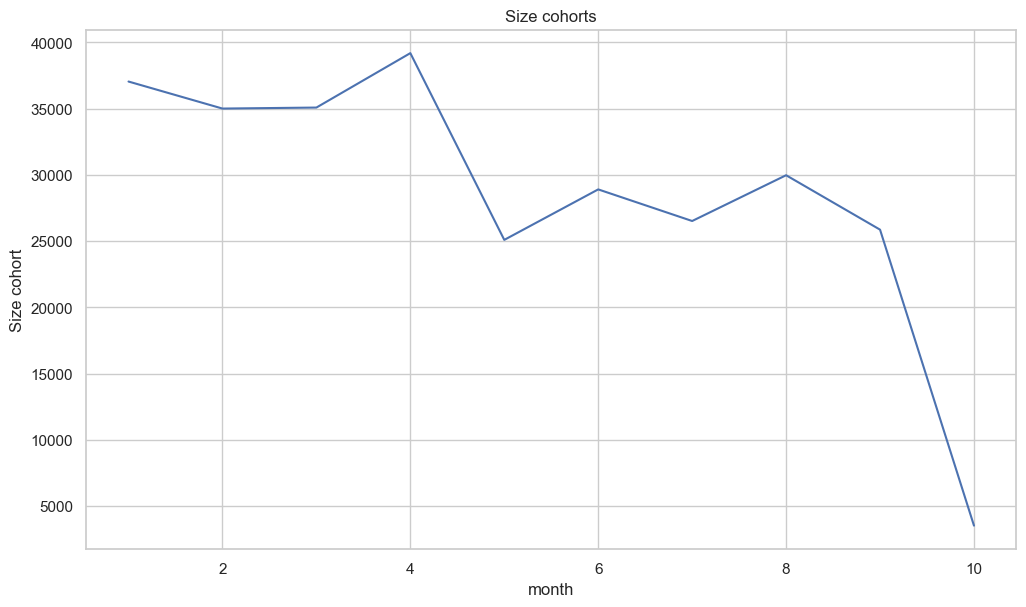

In [67]:
sns.lineplot(data=cohort_size, x='cohort', y='size_cohort')
plt.ylabel('Size cohort')
plt.xlabel('month')
plt.title('Size cohorts');

In [68]:
# валовая прибыль по когортам
gross_revenue = checks_devices.groupby('cohort').agg({'Rub': 'sum'})
gross_revenue.T

cohort,1,2,3,4,5,6,7,8,9,10
Rub,275473,247264,272644,215298,145634,146445,121524,123725,51863,1643


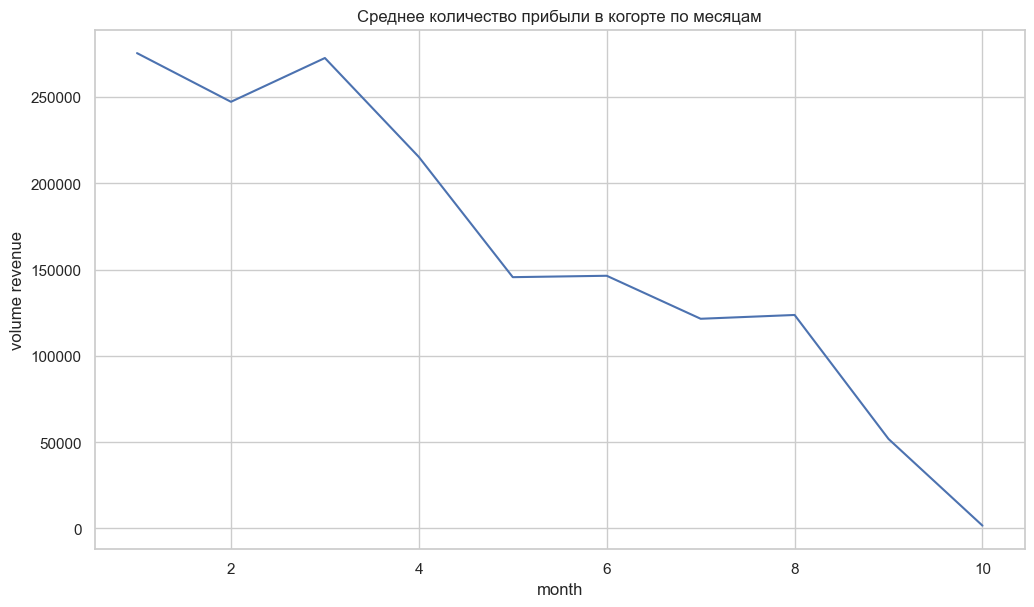

In [69]:
sns.lineplot(data=gross_revenue, x='cohort', y='Rub')
plt.ylabel('volume revenue')
plt.xlabel('month')
plt.title('Среднее количество прибыли в когорте по месяцам');

In [70]:
month_0 = gross_revenue.iloc[[0]].values[0][0]
month_9 = gross_revenue.iloc[[9]].values[0][0]
print('уменьшение валовой прибыли на', round(100 - month_8 / month_0 * 100), '% за весь период жизни когорты')

уменьшение валовой прибыли на 91 % за весь период жизни когорты


#### Вывод

90% чеков колеблятся в значениях между 11.4 и 15.4 в диапазоне  +/- 15% от среднего значения, флуктуации между когортами не значительные.

Средние показатели когорт:   
24% рост среднего чека с 1 по 7 месяц, что положительно сказывается на прибыли 

Когорта уменьшается на 30% за 9 месяцев, это связано с постепенным оттоком клиентов.  
Критичным моментом является снижение расходов на привлечение что приводит к оттоку покупателей.  
Некоторые рекламные каналы показывают хорошую эффективность привлечения покупателей (об этом ниже)

Среднее количество прибыли в когорте по месяцам за 9 месяцев снижается на 91%, это етественный процесс связанный с окончанием LV срока жизни пользователей у когорт.

<hr>

### Источники трафика и стоимость привлечения

Сравнение по источникам (бесплатные, плантные):  
количество пользователей  
количество покупателей  
конверсия в покупателя  
средняя цена привлечения пользователя  
средний доход с пользователя  
доля рекламных расходов в стоимости товара  
стоимость привлечения  
доход (в млн.)

In [71]:
# количествоо покупателей по источникам
customers = checks.merge(devices, on='UserID', how='left').merge(installs, on='DeviceID', how='left') \
    .groupby('Source').agg({'DeviceID': 'nunique'}).reset_index().rename(columns={'DeviceID': 'customers'})
#customers.head()

In [72]:
# посчитаем среднюю стоимость привлечения на пользователя по источнику
install_cost = installs.groupby('Source').agg({'InstallCost': 'sum', 'DeviceID': 'count'}) \
    .reset_index().rename(columns={'InstallCost': 'cost', 'DeviceID': 'users'})
install_cost['AvgCost'] = install_cost['cost'] / install_cost['users']
#install_cost.sort_values('AvgCost', ascending=False).head()

In [73]:
# найдём источники для каждой покупки
checks_devices = checks.merge(devices, on='UserID', how='left')
#checks_devices.head()

In [74]:
# добавляем пользователей которые не покупали
source_checks = checks_devices.merge(installs, on='DeviceID', how='outer') \
    [['Source', 'DeviceID', 'InstallationDate', 'Rub']]
#source_checks

In [75]:
# считаем средний доход на пользователя по источнику
user_acquisition = source_checks.groupby('Source').agg({'Rub': 'sum', 'DeviceID': 'nunique'}) \
    .reset_index().rename(columns={'Rub': 'revenue', 'DeviceID': 'users'})
user_acquisition['AvgRevenue'] = user_acquisition['revenue'] / user_acquisition['users']
user_acquisition = user_acquisition[['Source', 'revenue', 'AvgRevenue']]
#user_acquisition.sort_values('AvgRevenue', ascending=False).head()

In [76]:
# объединяем все данные
sources = user_acquisition.merge(install_cost, on='Source').merge(customers, on='Source', how='left')
sources['conversion'] = sources['customers'] / sources['users']
sources['profitability'] = sources['AvgCost'] / sources['AvgRevenue']
sources.sort_values('profitability').head()

,Source,revenue,AvgRevenue,cost,users,AvgCost,customers,conversion,profitability
19,Source_7,3667.0,2.763376,0.0,1327,0.0,55.0,0.041447,0.0
5,Source_18,1900.0,3.130148,0.0,607,0.0,30.0,0.049423,0.0
6,Source_19,156.0,2.166667,0.0,72,0.0,4.0,0.055556,0.0
14,Source_27,1016533.0,6.153794,0.0,165188,0.0,10719.0,0.064890,0.0
13,Source_26,498.0,1.791367,0.0,278,0.0,22.0,0.079137,0.0


In [77]:
def describe_sources(data):
    revenue = data.revenue
    users = data.users
    AvgRevenue = revenue.sum() / users.sum()
    cost = data.cost
    AvgCost = cost.sum() / users.sum()
    customers = data.customers
    conversion = data.conversion
    profitability = AvgCost / AvgRevenue
    return {'revenue': revenue.sum(), 'customers': customers.sum(), 'AvgRevenue': AvgRevenue.mean(), \
            'cost': cost.sum(), 'users': users.sum(), 'AvgCost': AvgCost.mean(), 'conversion': conversion.mean(), \
            'profitability': profitability.mean(), 'Source': data.Source.tolist()}

In [78]:
# определяем допустимый размер доли рекламных расходов в стоимости товаров
allowable = 0.3
allowable_level = round(allowable * 100)

In [79]:
# бесплатные источники
free = describe_sources(sources[sources.profitability == 0])
free['name'] = 'free'
#free

In [80]:
# платные источники
paid = describe_sources(sources[(sources.profitability != np.inf) & (sources.profitability > 0)])
paid['name'] = 'paid'
#paid

In [81]:
# бесполезные источники
useless = describe_sources(pd.concat([sources[sources.profitability == np.inf], \
                                      sources[np.isnan(sources.profitability)]]))
useless['name'] = 'useless'

/var/folders/d0/q70bc_ls2vb0njcl7y29z3g00000gn/T/ipykernel_8211/2667405112.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  profitability = AvgCost / AvgRevenue


In [82]:
type_source = [free, paid, useless]
type_metric = ['users', 'customers', 'conversion', 'AvgCost', 'AvgRevenue', 'profitability', 'cost', 'revenue']
describe = ['количество пользователей', 'количество покупателей', 'конверсия в покупателя', 'средняя цена привлечения пользователя', \
            'средний доход с пользователя',  'доля рекламных расходов в стоимости товара', 'стоимость привлечения','доход (в млн.)']

In [83]:
def get_info(type_source, type_metric):
    plt.figure(figsize=(15, 15))
    for i in range(8): 
        x, y = [], []
        for v in range(len(type_source)):
            y.append(type_source[v][type_metric[i]])
            x.append(type_source[v]['name'])
        sp = plt.subplot(331 + i)
        plt.bar(x, y)
        plt.title(describe[i])

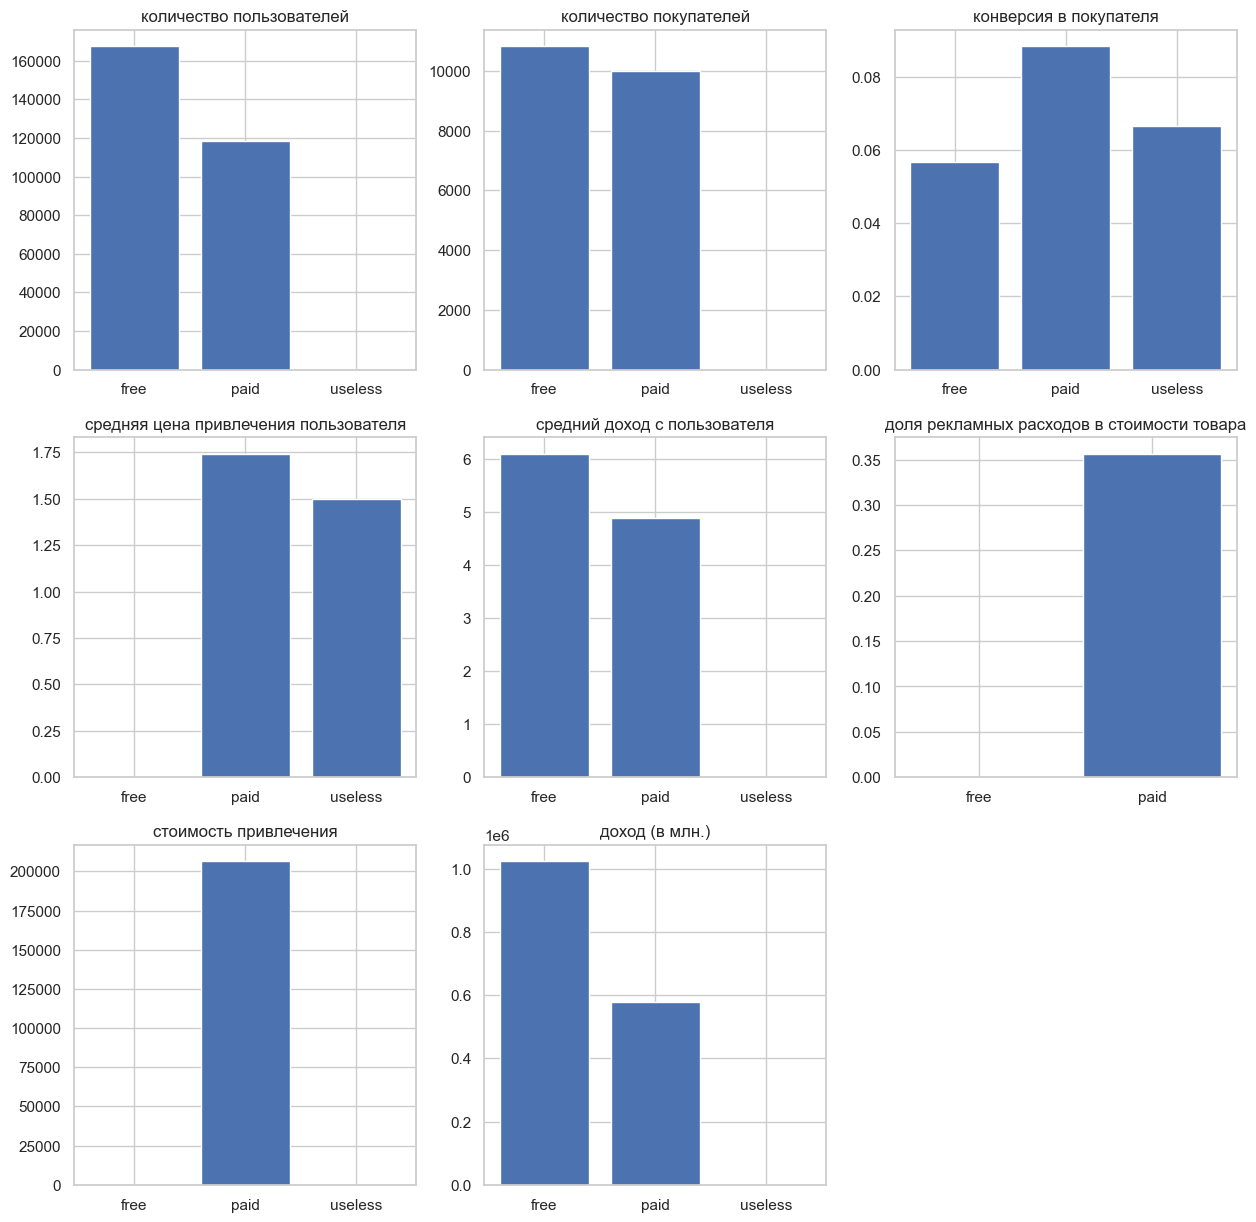

In [84]:
get_info(type_source, type_metric)

### Резюме

Пользователей:  
60% из бесплатных источников  
40% из платных источников

CR1 конверсия в покупку платных источнтков на 30% выше чем бесплатных

45% покупателей из бесплатных источников  
55% покупателей из платных источников

4.8 средний чек пользователя из бесплатного источника  
6.1 средний чек пользователя из платного источника  

1.75 средний расход на рекламу
0.36 доля рекламных расходов от прибыли

206440 расходы на привлечение 

1022872 прибыль из бесплатных источников
578641 прибыль из платных источников  

### Прибыль по источникам трафика

In [85]:
# прибыль по источникам и месяцам
revenue_by_month = checks[checks.Rub > 0].merge(devices, on='UserID', how='left') \
.merge(installs, on='DeviceID', how='left')[[ 'DeviceID', 'UserID', 'BuyDate', 'Rub', 'Source']]
revenue_by_month['month'] = revenue_by_month['BuyDate'].dt.month
#revenue_by_month.head()

In [86]:
revenue_by_month = revenue_by_month.groupby(['Source', 'month']).agg({'Rub': 'sum', 'UserID': 'nunique'}) \
    .reset_index().rename(columns={'Rub': 'revenue', 'UserID': 'customer'})
#revenue_by_month.head()

In [87]:
# рекламные расходы по источникам и месяцам
cost_by_month = installs.copy()
cost_by_month['month'] = cost_by_month['InstallationDate'].dt.month
cost_by_month = cost_by_month.groupby(['Source', 'month']).agg({'InstallCost': 'sum'}).reset_index() \
    .rename(columns={'InstallCost': 'cost'})
#cost_by_month.head()

In [88]:
# создадим таблицу всех источников и месяцов
uniq_source = installs.Source.unique().tolist()
uniq_months = cost_by_month['month'].unique().tolist()
var_table = pd.DataFrame(list(product(uniq_source, uniq_months)), columns=['Source', 'month'])
#var_table.head()

In [89]:
# добавим данные
var_table = var_table.merge(revenue_by_month, on=['Source', 'month'], how='left') \
    .merge(cost_by_month, on=['Source', 'month'], how='left')
#var_table = var_table.fillna(0)
var_table['cost'] = round(var_table['cost'])
var_table['profitability'] = round(var_table['cost'] / var_table['revenue'] * 100)
var_table['ARPPU'] = round(var_table['revenue'] / var_table['customer'])
var_table.replace([np.inf, -np.inf], np.nan, inplace=True)
var_table = var_table[var_table.cost > 0]
var_table.head()

,Source,month,revenue,customer,cost,profitability,ARPPU
0,Source_14,1,10633.0,312.0,7640.0,72.0,34.0
1,Source_14,2,15156.0,422.0,5820.0,38.0,36.0
2,Source_14,3,15259.0,427.0,5719.0,37.0,36.0
3,Source_14,4,29274.0,889.0,16597.0,57.0,33.0
4,Source_14,5,28289.0,611.0,5313.0,19.0,46.0


In [90]:
def get_pfbl_chart(data, index, columns, values, title, vmin, vmax):
    chart = data.pivot_table(index=index, columns=columns, values=values, aggfunc='mean')
    plt.figure(figsize=(12, 6.75))
    line = var_table.groupby(index).agg({values: 'mean'}).reset_index()
    plt.title(title)
    sns.barplot(data=line, y=index, x=values);
    plt.show()
    plt.title(title)
    sns.heatmap(chart, annot=True, fmt='.0f', vmin=vmin, vmax=vmax, cmap= 'Reds');

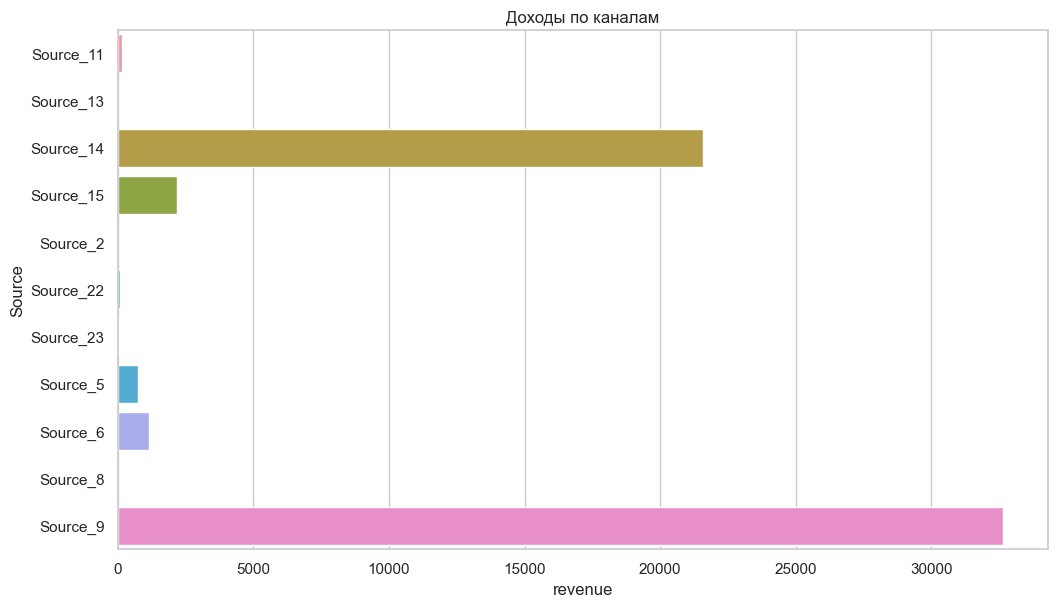

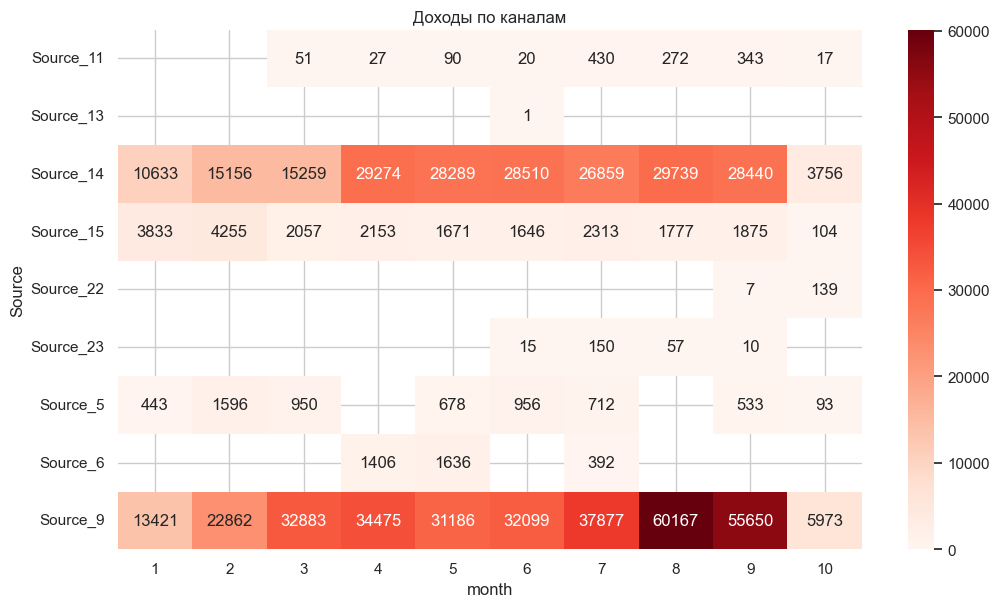

In [91]:
get_pfbl_chart(var_table, 'Source', 'month', 'revenue', 'Доходы по каналам', 0, var_table.revenue.max())

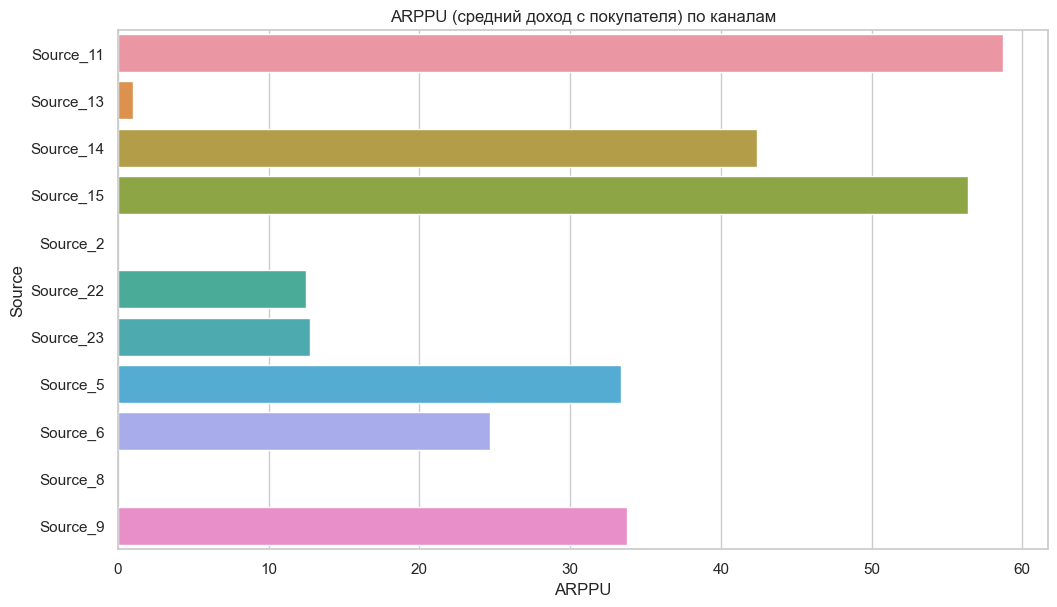

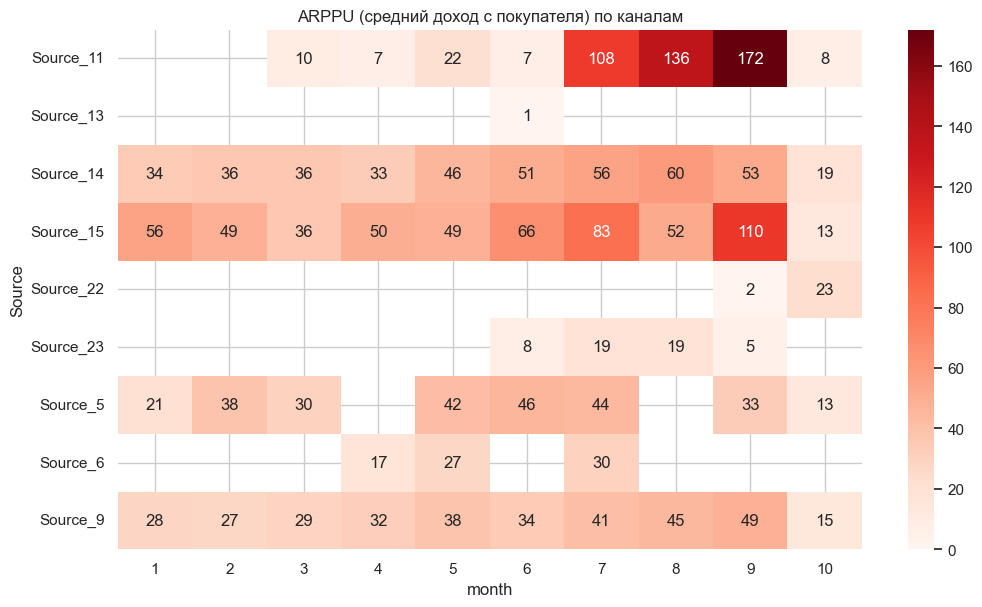

In [92]:
get_pfbl_chart(var_table, 'Source', 'month', 'ARPPU', 'ARPPU (средний доход с покупателя) по каналам', \
               0, var_table.ARPPU.max())

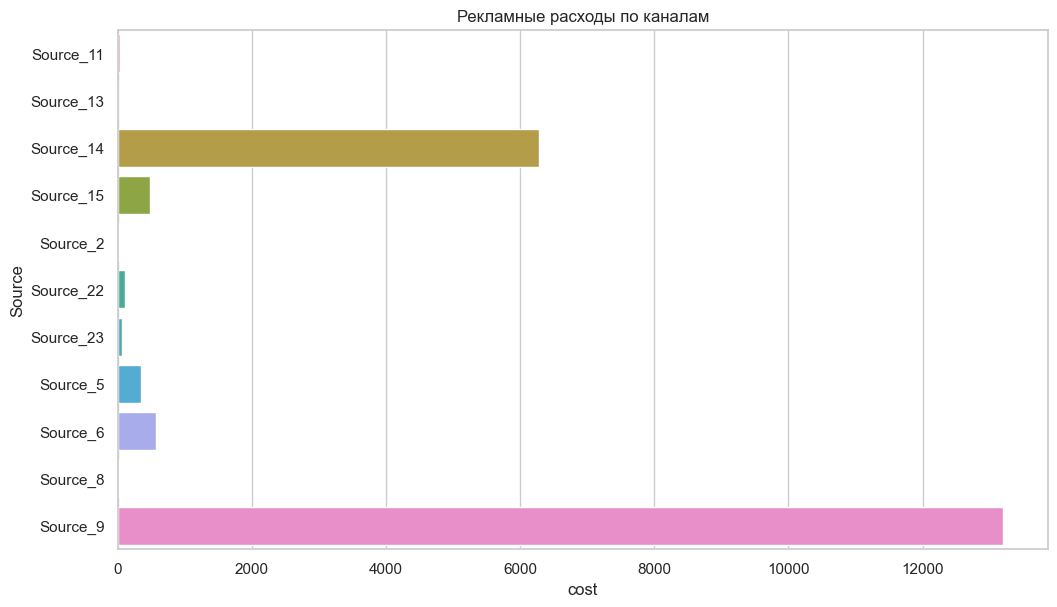

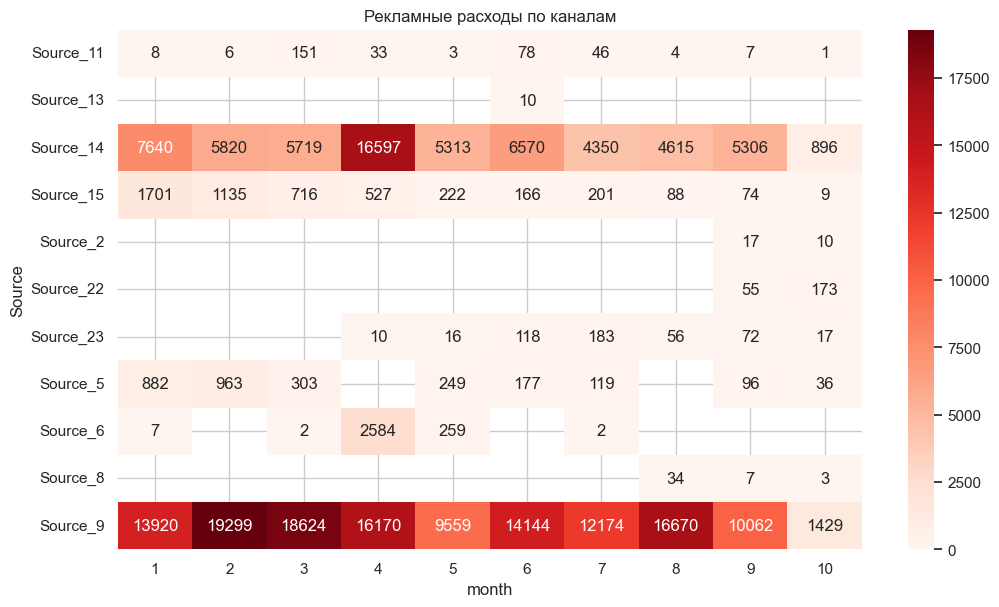

In [93]:
get_pfbl_chart(var_table, 'Source', 'month', 'cost', 'Рекламные расходы по каналам', 0, var_table.cost.max())

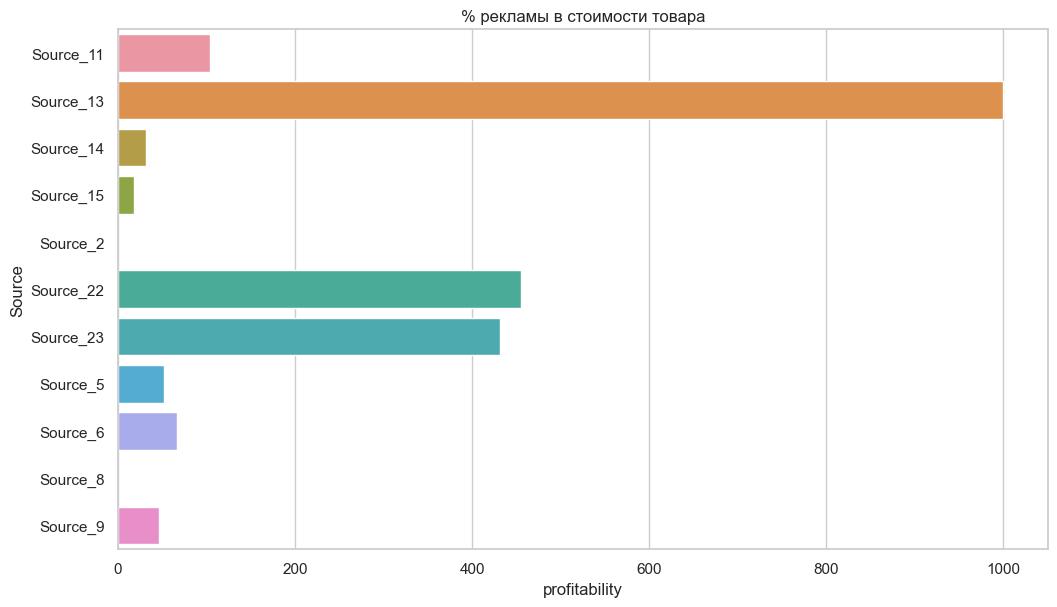

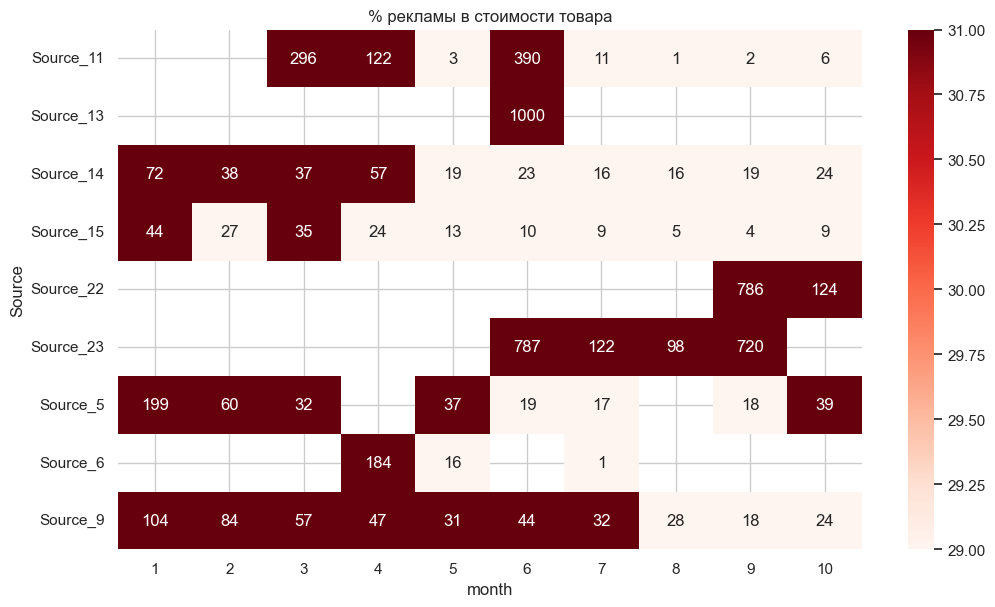

In [94]:
get_pfbl_chart(var_table, 'Source', 'month', 'profitability', '% рекламы в стоимости товара', 29, 31)

### Резюме

Доходы по каналам:  
топ 14, 9  
средний 5, 6, 15

ARPPU (средний доход с покупателя) по каналам:  
топ 11, 14, 15  
средний 5, 6, 9

% рекламы в стоимости товара:   
топ 15, 14, 9  
средний 5, 6, 11

Наиболее привлекательным выглядят каналы в порядке убывания: 14, 15, 9, 11, 5, 6

Канал 6 приостановлен
Каналы 14, 9 уже приносят основной платный трафик

Рекомендуется увеличить привлечение из 15 и 11 канала (у них самый высокий ARPPU за последние 3 месяца)

<hr>

## Расчет и оценка LTV, CAC и ROMI по источникам трафика

Рассмотрим источники трафика:  
- все вместе  
- только платные вместе  
- платные каждый по отдельности  

В каждом из случаев посчитаем LTV, CAC и сравним ROMI по когортам.

### Все источники трафика вместе

In [95]:
# создание когорт по installs
inst = installs.copy()
inst['cohort'] = inst['InstallationDate'].dt.month
inst['name_cohort'] = inst['InstallationDate'].dt.strftime('%Y-%m')

# сохраним понятные названия когорт
inst_coh = inst[['DeviceID', 'InstallCost', 'Source', 'Platform', 'cohort']]
#inst_coh.head()

In [96]:
# понятные имена когорт
name_cohort = inst[['cohort', 'name_cohort']].drop_duplicates()
#name_cohort.head()

In [97]:
# размеры и расходы привлечения users когорт
usr_coh = inst_coh.groupby('cohort').agg({'DeviceID': 'count', 'InstallCost': 'sum'}) \
    .rename(columns={'DeviceID': 'size_usr_coh', 'InstallCost': 'cost'}).reset_index()
#usr_coh.head()

In [98]:
# создание когорт по checks
check_coh = checks[checks.Rub > 0].merge(devices, on='UserID', how='left').merge(inst_coh, on='DeviceID', how='left')
check_coh['month'] = check_coh['BuyDate'].dt.month - check_coh['cohort']
check_coh = check_coh[['DeviceID', 'Rub', 'Source', 'Platform', 'cohort', 'month']]
#check_coh.head()

In [99]:
# размер и прибыль buyers когорт
buy_coh = check_coh.groupby('cohort').agg({'DeviceID': 'nunique', 'Rub': 'sum'}) \
    .rename(columns={'DeviceID': 'size_buy_coh', 'Rub': 'revenue'}).reset_index()
#buy_coh.head()

In [100]:
# считаем LTV
table = check_coh.groupby(['cohort', 'month']).agg({'Rub': 'sum'}).reset_index() \
    .merge(buy_coh, on='cohort', how='left').merge(usr_coh, on='cohort', how='left') \
    .merge(name_cohort, on='cohort', how='left')
table['cum'] = table.groupby('cohort')['Rub'].cumsum()

# считаем LTV
table['LTV'] = round(table['Rub'] / table['size_buy_coh'], 2)

,cohort,month,Rub,size_buy_coh,revenue,size_usr_coh,cost,name_cohort,cum,LTV
0,1,0,69006,2827,275473,37039,24157.37,2019-01,69006,24.41
1,1,1,45146,2827,275473,37039,24157.37,2019-01,114152,15.97
2,1,2,29797,2827,275473,37039,24157.37,2019-01,143949,10.54
3,1,3,23654,2827,275473,37039,24157.37,2019-01,167603,8.37
4,1,4,20484,2827,275473,37039,24157.37,2019-01,188087,7.25


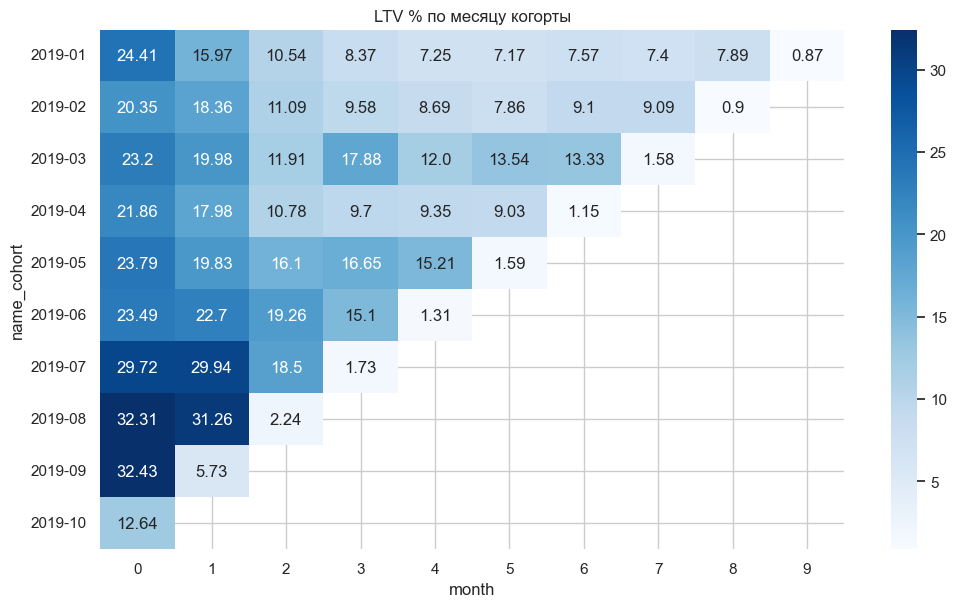

In [101]:
display(table.head())
get_cohort_chart(table, 'name_cohort', 'month', 'LTV', 'LTV % по месяцу когорты', '')

,cohort,month,Rub,size_buy_coh,revenue,size_usr_coh,cost,name_cohort,cum,LTV,LTV_cum
0,1,0,69006,2827,275473,37039,24157.37,2019-01,69006,24.41,24.41
1,1,1,45146,2827,275473,37039,24157.37,2019-01,114152,15.97,40.38
2,1,2,29797,2827,275473,37039,24157.37,2019-01,143949,10.54,50.92
3,1,3,23654,2827,275473,37039,24157.37,2019-01,167603,8.37,59.29
4,1,4,20484,2827,275473,37039,24157.37,2019-01,188087,7.25,66.53


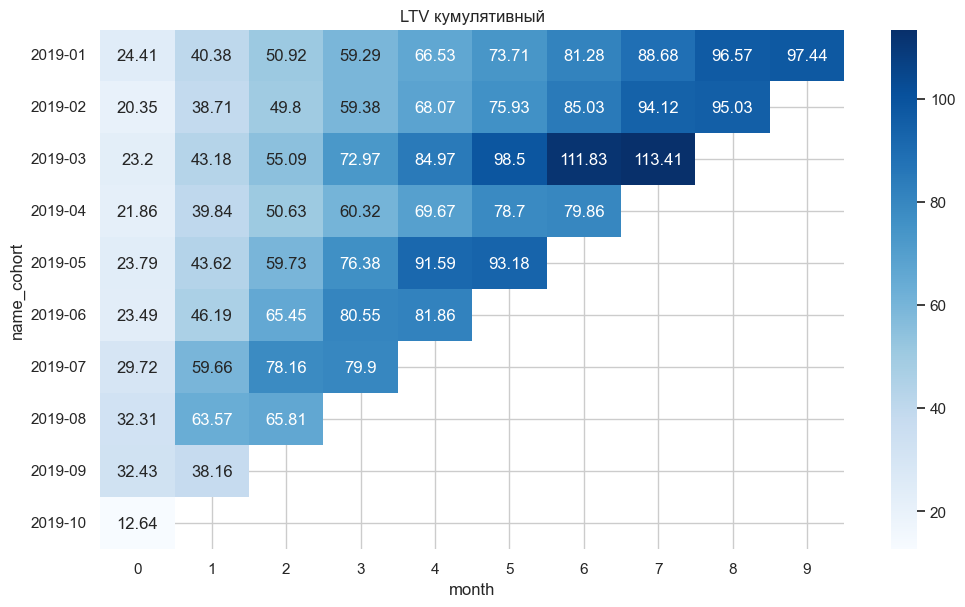

In [102]:
# считаем кумулятивный LTV
table['LTV_cum'] = round(table['cum'] / table['size_buy_coh'], 2)
display(table.head())
get_cohort_chart(table, 'name_cohort', 'month', 'LTV_cum', 'LTV кумулятивный', '')

Рекламные вложения окупаются в среднем на 3 месяц


month,0,1,2,3,4,5,6,7,8,9
LTV_cum,24.42,45.923333,59.44875,69.827143,77.115,84.004,89.5,98.736667,95.8,97.44


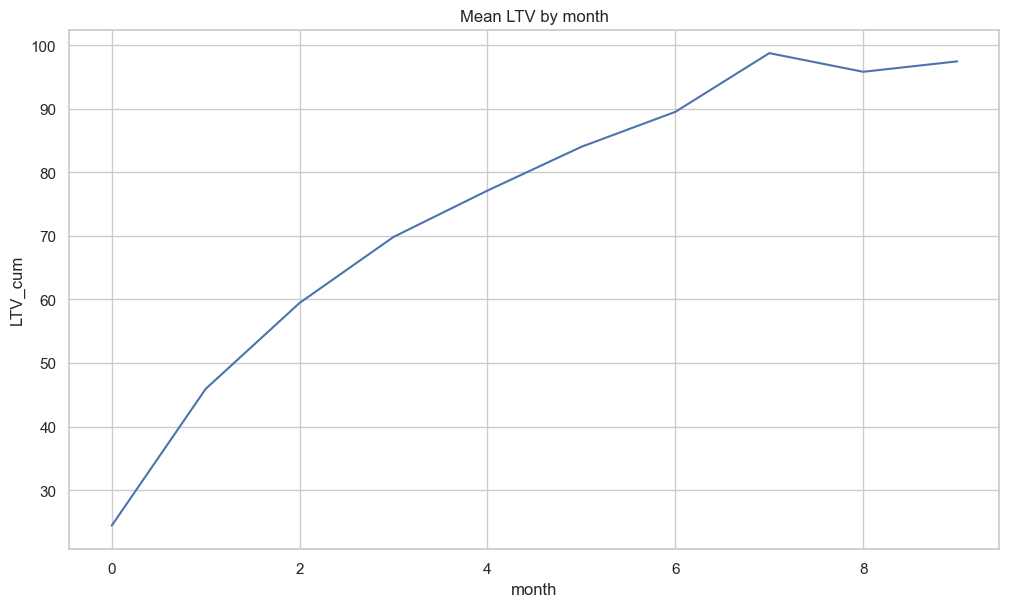

In [103]:
# считаем среднее значение LTV по всем когортам
ltv_cum = table.groupby('month').agg({'LTV_cum': 'mean'})
print('Рекламные вложения окупаются в среднем на 3 месяц')
display(ltv_cum.T)
sns.lineplot(data=ltv_cum, x='month', y='LTV_cum')
plt.title('Mean LTV by month');

In [104]:
# построение графика ROMI
def get_romi_chart(data, index, columns, values, title):
    chart = data.pivot_table(index=index, columns=columns, values=values, aggfunc='mean') 
    plt.figure(figsize=(12, 6.75))
    plt.title(title)
    sns.heatmap(chart, annot=True, fmt='', vmin=0.9, vmax=1.1, cmap= 'RdYlGn');

,cohort,month,Rub,size_buy_coh,revenue,size_usr_coh,cost,name_cohort,cum,LTV,LTV_cum,CAC,ROMI
0,1,0,69006,2827,275473,37039,24157.37,2019-01,69006,24.41,24.41,8.55,0.86
1,1,1,45146,2827,275473,37039,24157.37,2019-01,114152,15.97,40.38,8.55,1.42
2,1,2,29797,2827,275473,37039,24157.37,2019-01,143949,10.54,50.92,8.55,1.79
3,1,3,23654,2827,275473,37039,24157.37,2019-01,167603,8.37,59.29,8.55,2.08
4,1,4,20484,2827,275473,37039,24157.37,2019-01,188087,7.25,66.53,8.55,2.33


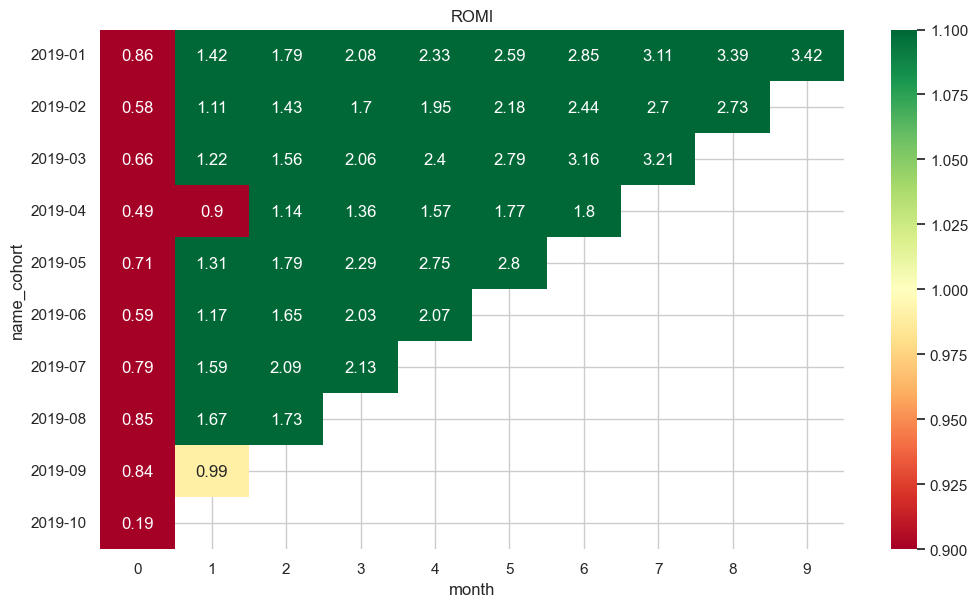

In [105]:
# считаем CAC (стоимость привлечения покупателя)
table['CAC'] = round(table['cost'] / table['size_buy_coh'], 2)

# считаем ROMI (показатель окупаемости инвестиций)
break_even = 0.3 # точка безубыточности маркетинг бюджет
table['ROMI'] = round((table['LTV_cum'] * break_even / table['CAC']), 2)
#table['ROMI'] = round((table['LTV_cum'] - table['CAC']) / table['CAC'], 2)
display(table.head())
get_romi_chart(table, index='name_cohort', columns='month', values='ROMI', title='ROMI')

month,0,1,2,3,4,5,6,7,8,9
ROMI,0.656,1.264444,1.6475,1.95,2.178333,2.426,2.5625,3.006667,3.06,3.42


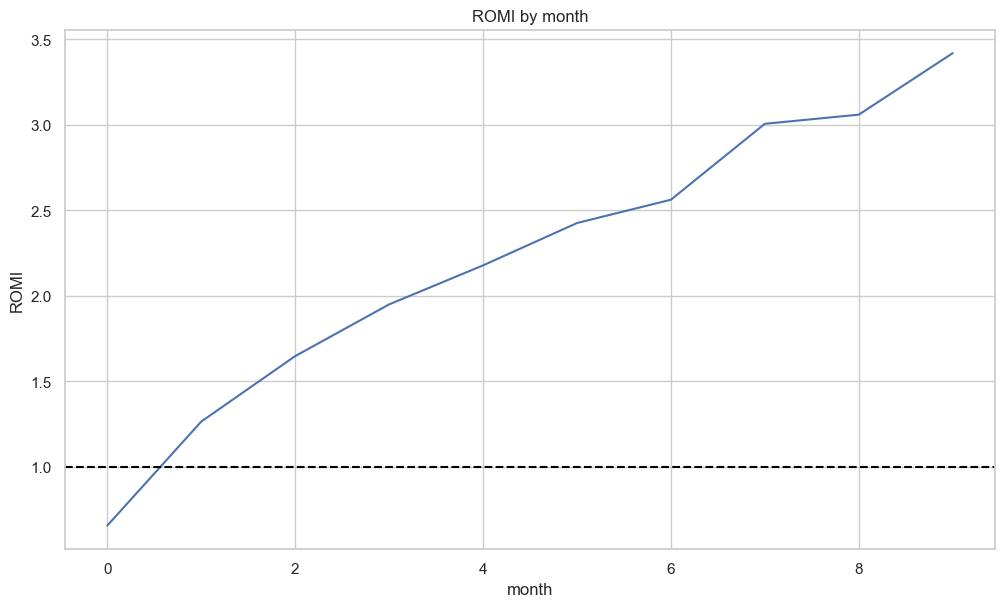

In [106]:
# считаем среднее значение ROMI по всем когортам
romi = table.groupby('month').agg({'ROMI': 'mean'})
display(romi.T)
sns.lineplot(data=romi, x='month', y='ROMI')
plt.axhline(y=1, color='black', linestyle='--')
plt.title('ROMI by month');

### Резюме
Общая картина показывает очень приличный ROMI (больше 1) спустя две недели с начала когорты. Это хороший показатель, но стоит учесть что он сильно искажён положительным влиянием бесплатных источников трафика.

### Платные источники трафика вместе

In [107]:
def get_by_source(source, installs, checks):
    print(source)
    
    # создание когорт по installs
    inst = installs[installs.Source.isin(source)].copy()
    inst['cohort'] = inst['InstallationDate'].dt.month
    inst['name_cohort'] = inst['InstallationDate'].dt.strftime('%Y-%m')
    
    # сохраним понятные названия когорт
    inst_coh = inst[['DeviceID', 'InstallCost', 'Source', 'Platform', 'cohort']]

    # понятные имена когорт
    name_cohort = inst[['cohort', 'name_cohort']].drop_duplicates()
    
    # размеры и расходы привлечения users когорт
    usr_coh = inst_coh.groupby('cohort').agg({'DeviceID': 'count', 'InstallCost': 'sum'}) \
        .rename(columns={'DeviceID': 'size_usr_coh', 'InstallCost': 'cost'}).reset_index()
    
    # создание когорт по checks
    check_coh = checks[checks.Rub > 0].merge(devices, on='UserID', how='left') \
        .merge(inst_coh, on='DeviceID', how='left')
    check_coh['month'] = check_coh['BuyDate'].dt.month - check_coh['cohort']
    check_coh = check_coh[check_coh.Source.isin(source)][['DeviceID', 'Rub', 'Source', 'Platform', 'cohort', 'month']]
    
    # размер и прибыль buyers когорт
    buy_coh = check_coh.groupby('cohort').agg({'DeviceID': 'nunique', 'Rub': 'sum'}) \
        .rename(columns={'DeviceID': 'size_buy_coh', 'Rub': 'revenue'}).reset_index()
    
    # считаем LTV
    table = check_coh.groupby(['cohort', 'month']).agg({'Rub': 'sum'}).reset_index() \
        .merge(buy_coh, on='cohort', how='left').merge(usr_coh, on='cohort', how='left') \
        .merge(name_cohort, on='cohort', how='left')
    table['cum'] = table.groupby('cohort')['Rub'].cumsum()

    # считаем LTV
    table['LTV'] = round(table['Rub'] / table['size_buy_coh'], 2)
    #get_cohort_chart(table, index='name_cohort', columns='month', values='LTV', title='LTV ' + str(source))
    #plt.show()
    
    # считаем кумулятивный LTV
    table['LTV_cum'] = round(table['cum'] / table['size_buy_coh'], 2)
    get_cohort_chart(table, index='name_cohort', columns='month', values='LTV_cum', title='LTV_cum_' + str(source), \
                     fmt='')
    plt.show()
    
    # считаем среднее значение LTV по всем когортам
    ltv_cum = table.groupby('month').agg({'LTV_cum': 'mean'})
    #display(ltv_cum.T)
    sns.lineplot(data=ltv_cum, x='month', y='LTV_cum')
    plt.title('Mean LTV by month ' + str(source));
    plt.show()
    
    # считаем CAC (стоимость привлечения покупателя)
    table['CAC'] = round(table['cost'] / table['size_buy_coh'], 2)

    # считаем ROMI (показатель окупаемости инвестиций)
    break_even = 0.3 # точка безубыточности маркетинг бюджет
    table['ROMI'] = round((table['LTV_cum'] * break_even / table['CAC']), 2)
    #table['ROMI'] = round((table['LTV_cum'] - table['CAC']) / table['CAC'], 2)
    get_romi_chart(table, index='name_cohort', columns='month', values='ROMI', title='ROMI ' + str(source))
    plt.show()
    
    # считаем среднее значение ROMI по всем когортам
    romi = table.groupby('month').agg({'ROMI': 'mean'})
    #display(romi.T)
    sns.lineplot(data=romi, x='month', y='ROMI')
    plt.axhline(y=1, color='black', linestyle='--')
    plt.title('ROMI by month ' + str(source));
    plt.show()
    
    display(table.head())

['Source_11', 'Source_13', 'Source_14', 'Source_15', 'Source_2', 'Source_22', 'Source_23', 'Source_5', 'Source_6', 'Source_8', 'Source_9']


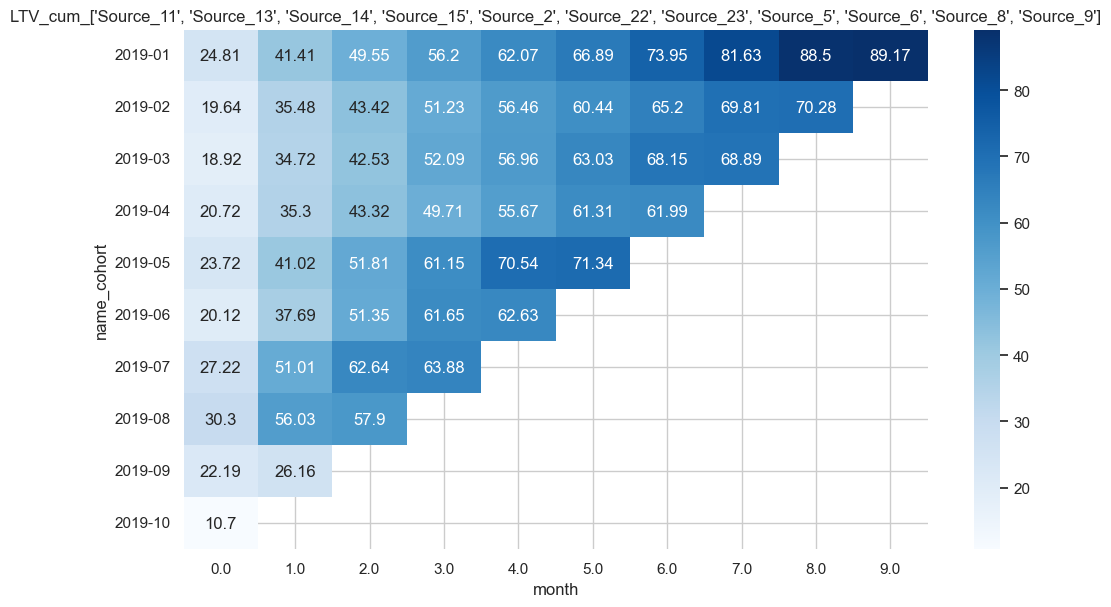

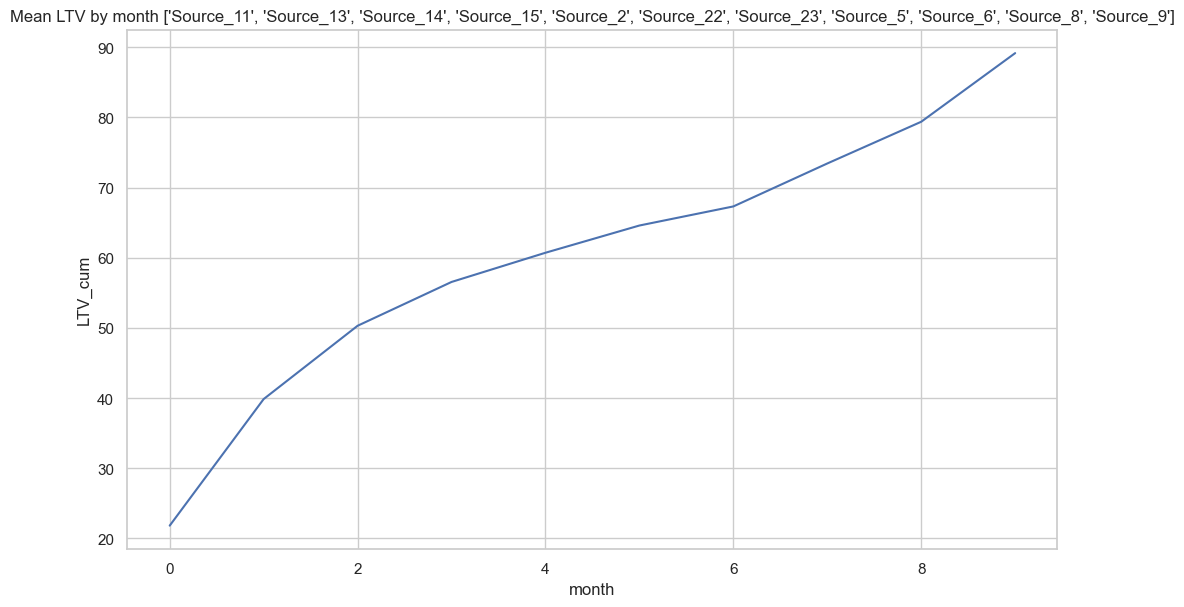

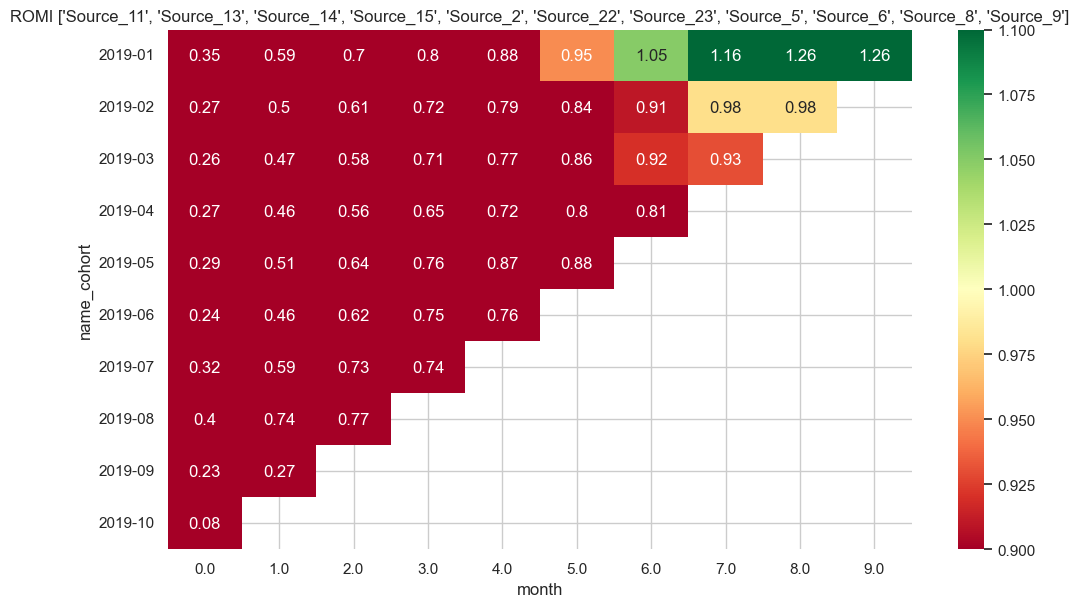

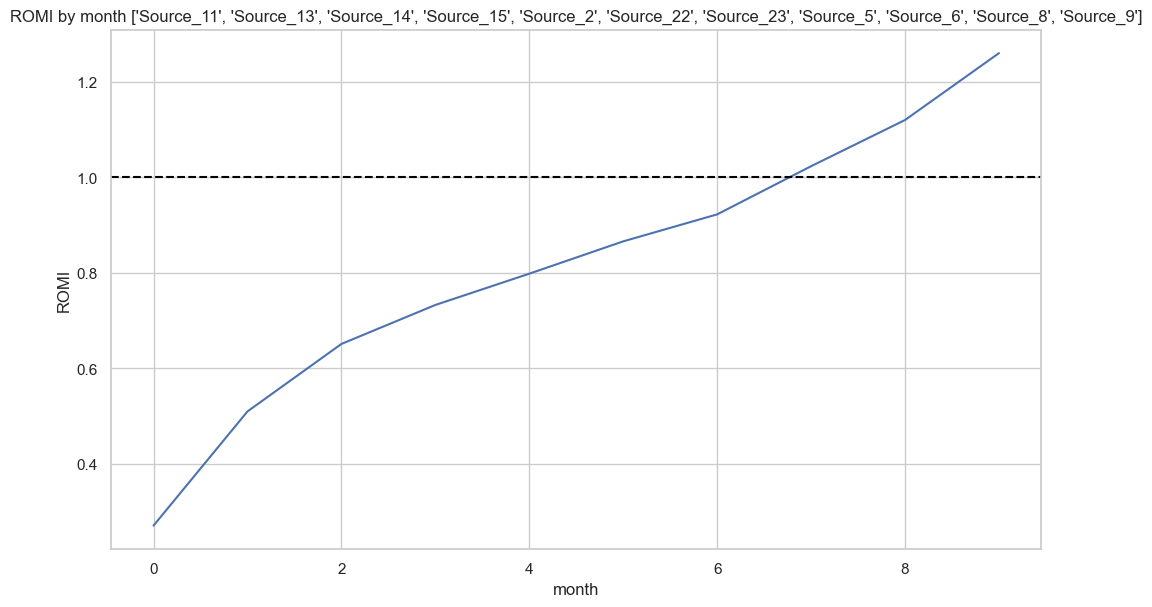

,cohort,month,Rub,size_buy_coh,revenue,size_usr_coh,cost,name_cohort,cum,LTV,LTV_cum,CAC,ROMI
0,1.0,0.0,28330,1142,101836,13871,24157.37,2019-01,28330,24.81,24.81,21.15,0.35
1,1.0,1.0,18965,1142,101836,13871,24157.37,2019-01,47295,16.61,41.41,21.15,0.59
2,1.0,2.0,9287,1142,101836,13871,24157.37,2019-01,56582,8.13,49.55,21.15,0.70
3,1.0,3.0,7604,1142,101836,13871,24157.37,2019-01,64186,6.66,56.20,21.15,0.80
4,1.0,4.0,6697,1142,101836,13871,24157.37,2019-01,70883,5.86,62.07,21.15,0.88


In [108]:
# платные источники трафика
paid_traffic_sources = sources[sources.cost > 0].Source.tolist()
get_by_source(paid_traffic_sources, installs, checks)

### Резюме
Платные источники трафика взятые вместе показывают менее радужную картину, когорты достигают ROMI=1 только к 7 месяцу.  
Это не так печально, но всё же неприемлемо долго.

Стоит упомянуть, что каналы запускаются постепенно, и достигают оптимальной цены привлечения в среднем только к 4 месяцу, поэтому стоит рассмотреть их по отдельности.

### Платные источники трафика по отдельности

['Source_9']


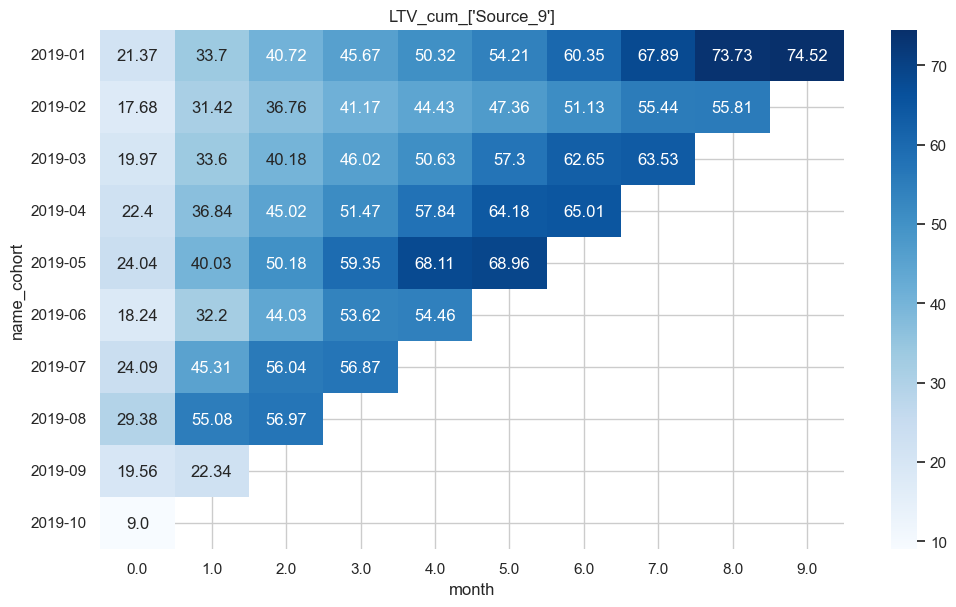

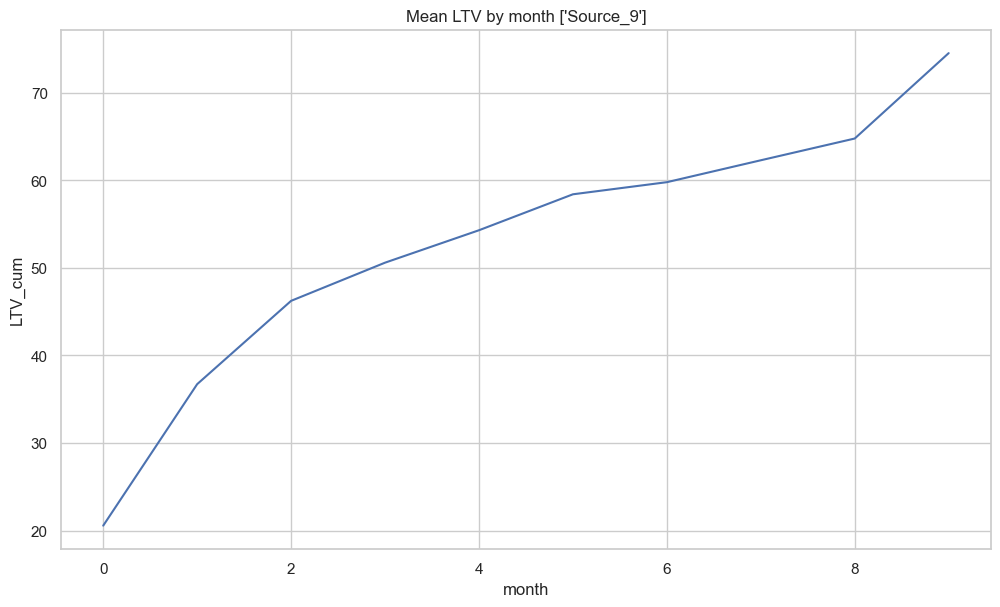

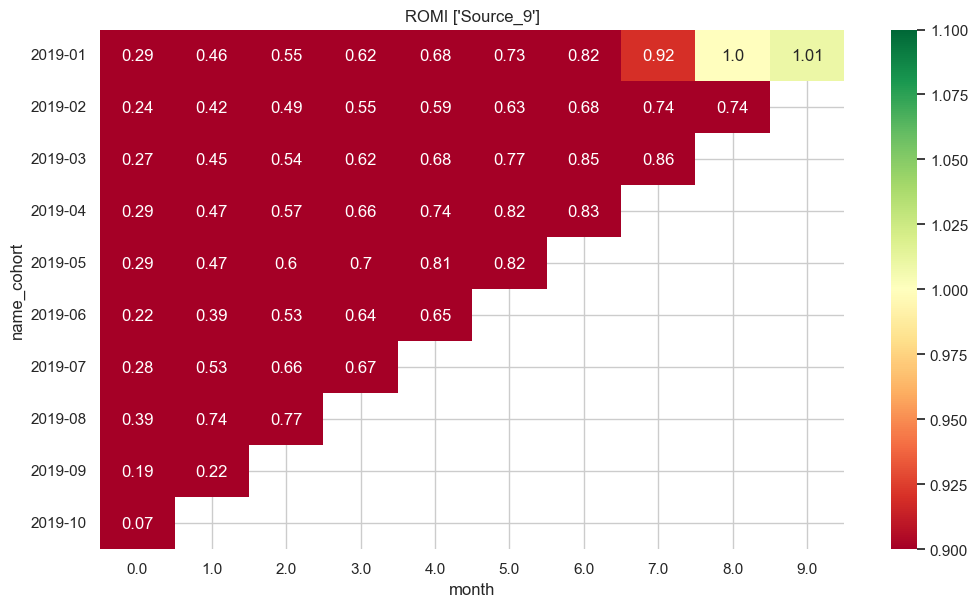

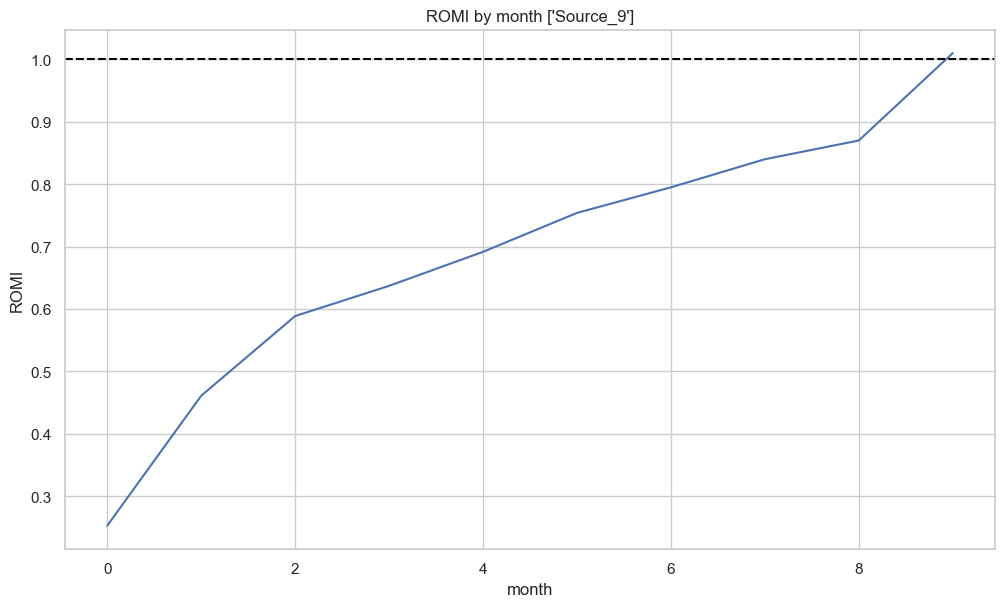

,cohort,month,Rub,size_buy_coh,revenue,size_usr_coh,cost,name_cohort,cum,LTV,LTV_cum,CAC,ROMI
0,1.0,0.0,13421,628,46800,7972,13920.47,2019-01,13421,21.37,21.37,22.17,0.29
1,1.0,1.0,7744,628,46800,7972,13920.47,2019-01,21165,12.33,33.70,22.17,0.46
2,1.0,2.0,4405,628,46800,7972,13920.47,2019-01,25570,7.01,40.72,22.17,0.55
3,1.0,3.0,3111,628,46800,7972,13920.47,2019-01,28681,4.95,45.67,22.17,0.62
4,1.0,4.0,2921,628,46800,7972,13920.47,2019-01,31602,4.65,50.32,22.17,0.68


['Source_14']


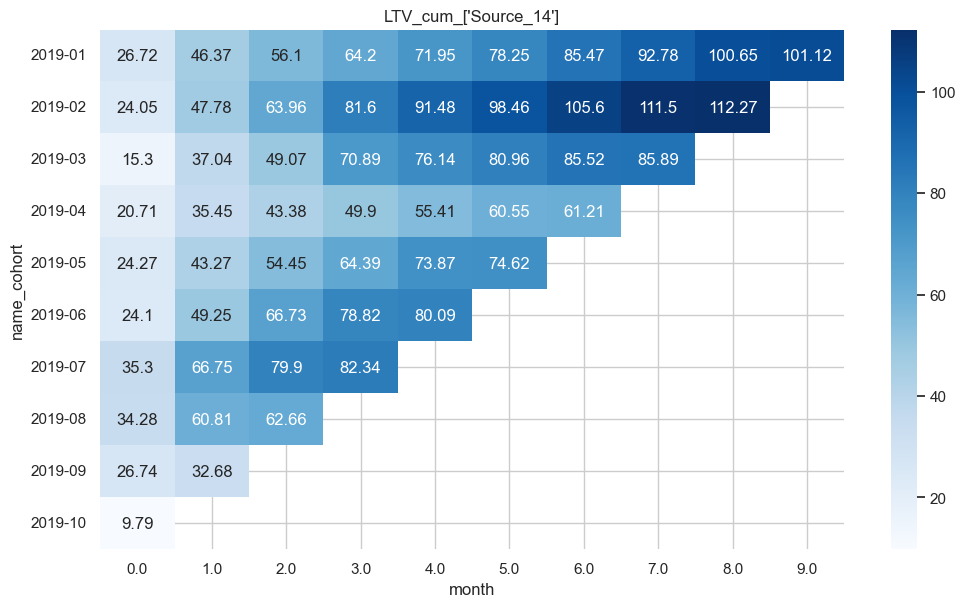

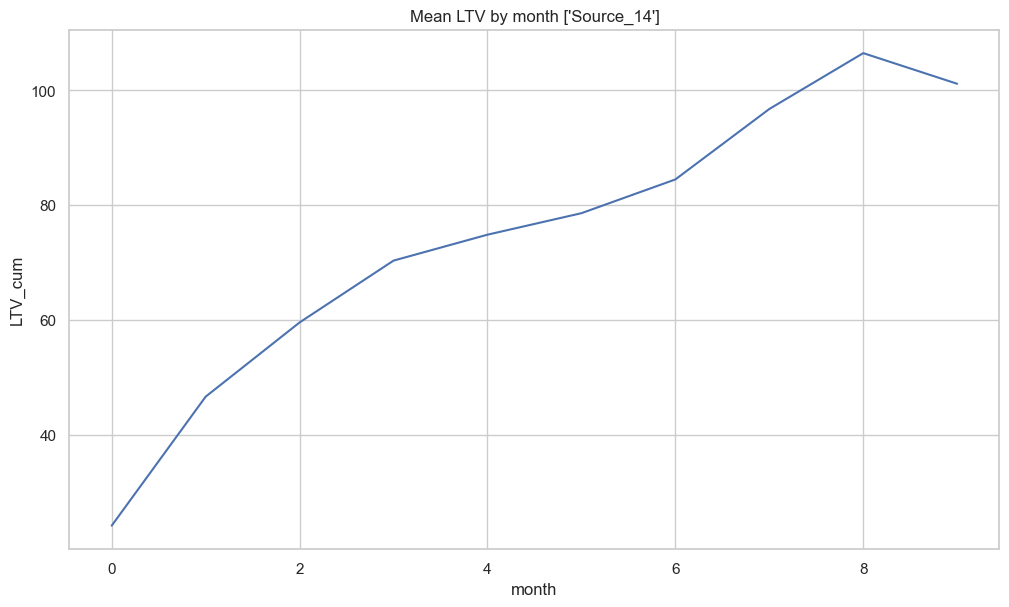

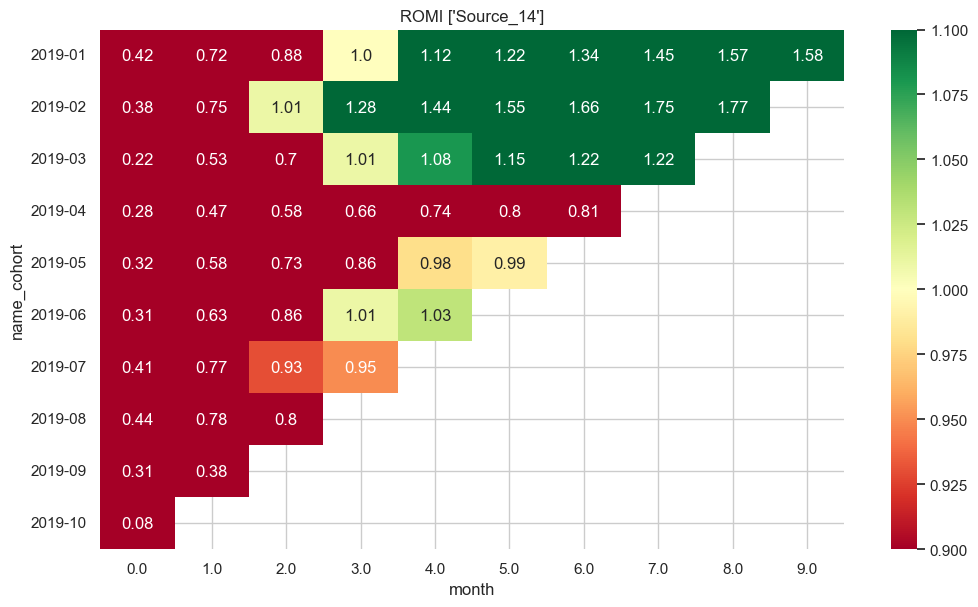

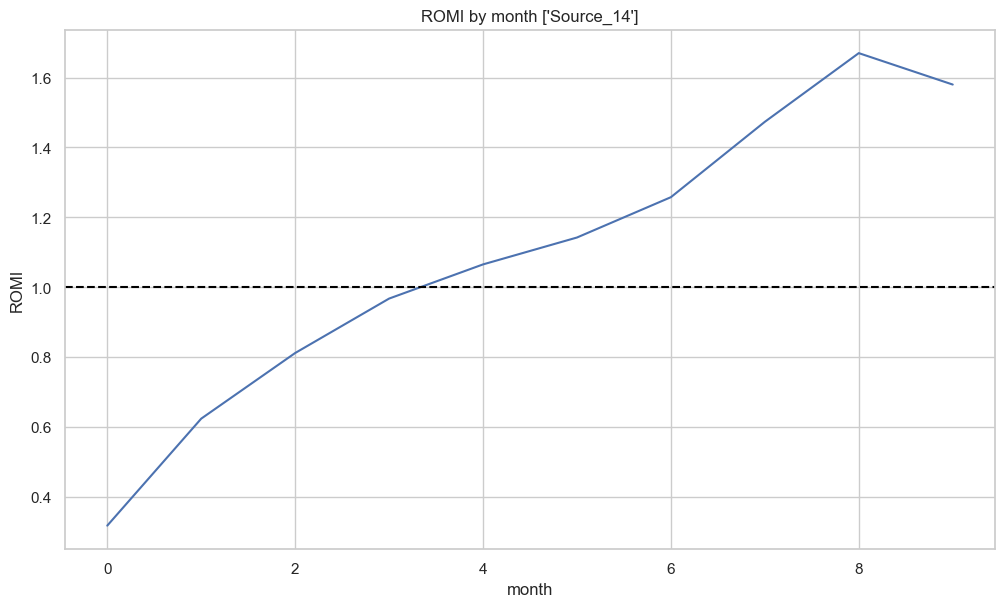

,cohort,month,Rub,size_buy_coh,revenue,size_usr_coh,cost,name_cohort,cum,LTV,LTV_cum,CAC,ROMI
0,1.0,0.0,10633,398,40245,4379,7639.66,2019-01,10633,26.72,26.72,19.2,0.42
1,1.0,1.0,7821,398,40245,4379,7639.66,2019-01,18454,19.65,46.37,19.2,0.72
2,1.0,2.0,3873,398,40245,4379,7639.66,2019-01,22327,9.73,56.10,19.2,0.88
3,1.0,3.0,3224,398,40245,4379,7639.66,2019-01,25551,8.10,64.20,19.2,1.00
4,1.0,4.0,3087,398,40245,4379,7639.66,2019-01,28638,7.76,71.95,19.2,1.12


['Source_15']


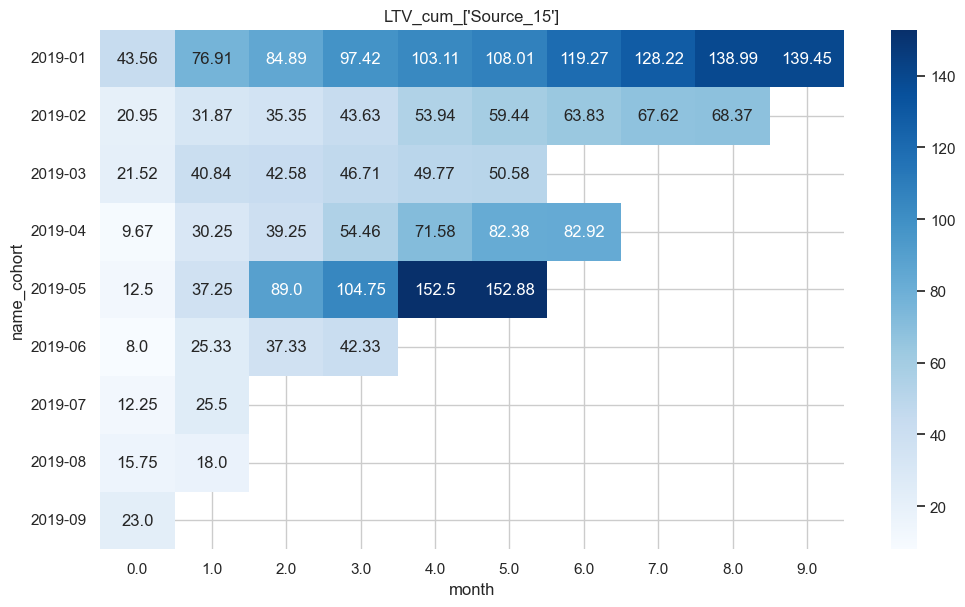

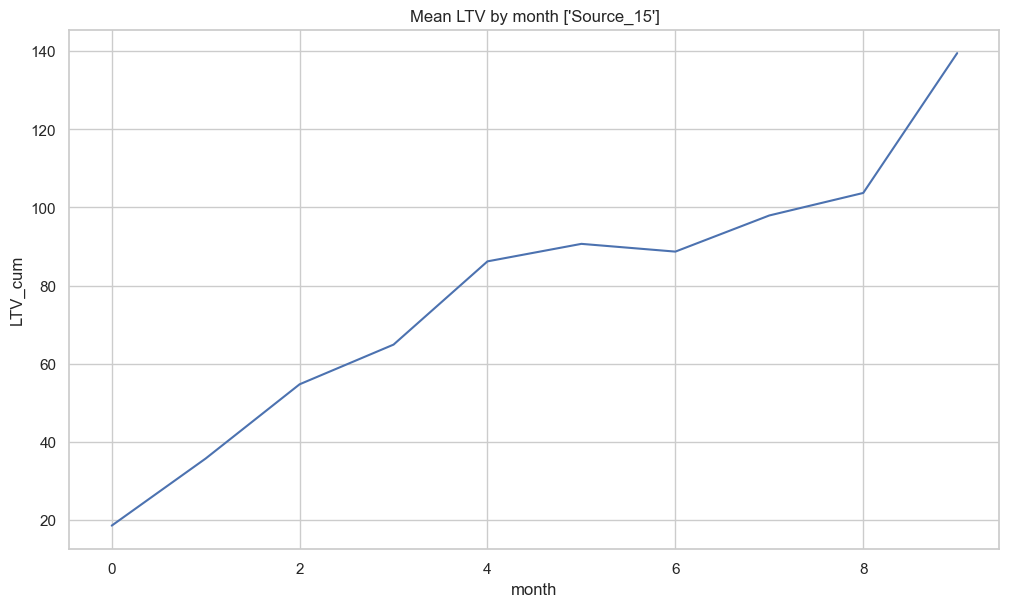

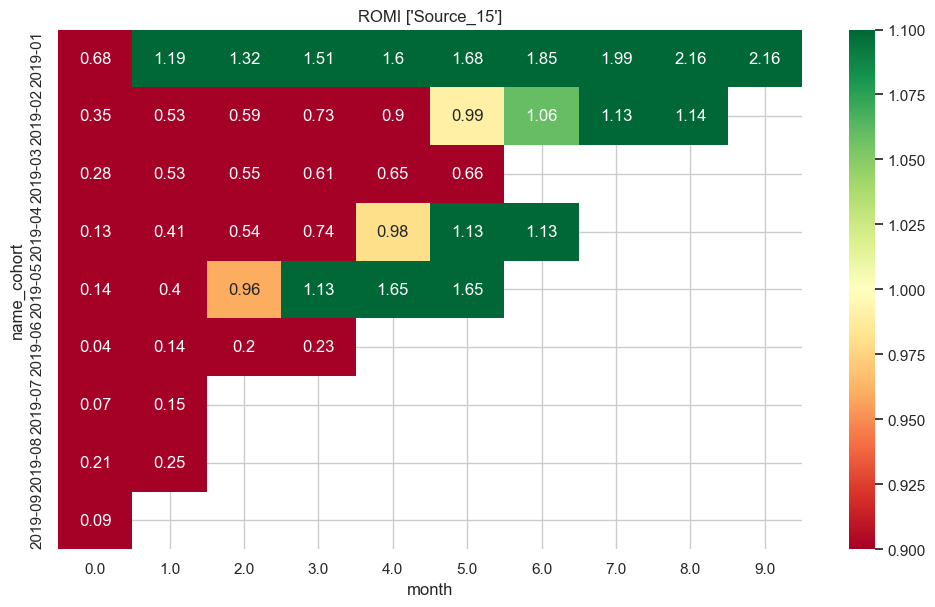

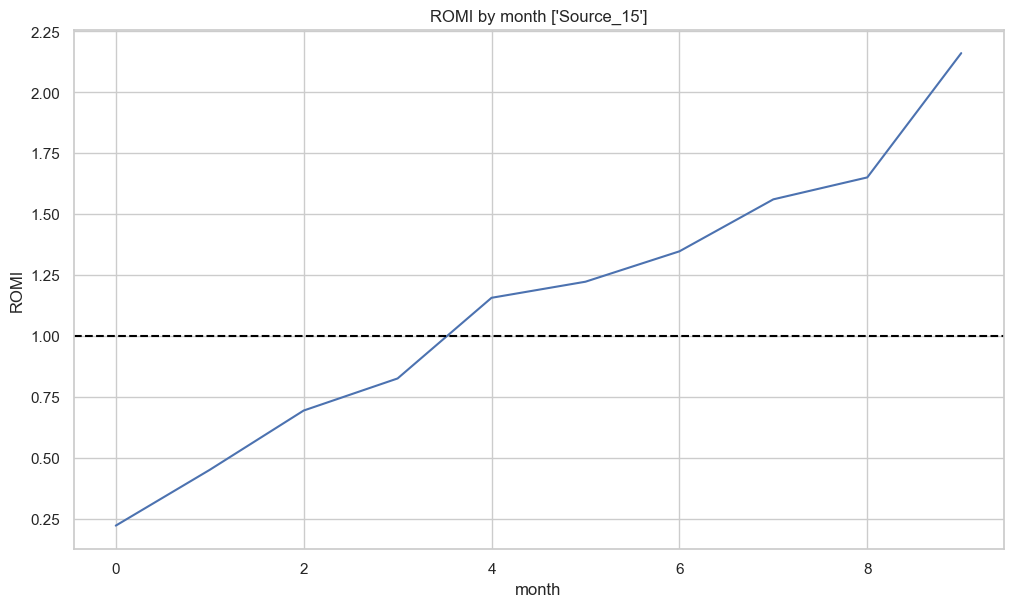

,cohort,month,Rub,size_buy_coh,revenue,size_usr_coh,cost,name_cohort,cum,LTV,LTV_cum,CAC,ROMI
0,1.0,0.0,3833,88,12272,991,1701.15,2019-01,3833,43.56,43.56,19.33,0.68
1,1.0,1.0,2935,88,12272,991,1701.15,2019-01,6768,33.35,76.91,19.33,1.19
2,1.0,2.0,702,88,12272,991,1701.15,2019-01,7470,7.98,84.89,19.33,1.32
3,1.0,3.0,1103,88,12272,991,1701.15,2019-01,8573,12.53,97.42,19.33,1.51
4,1.0,4.0,501,88,12272,991,1701.15,2019-01,9074,5.69,103.11,19.33,1.60


['Source_11']


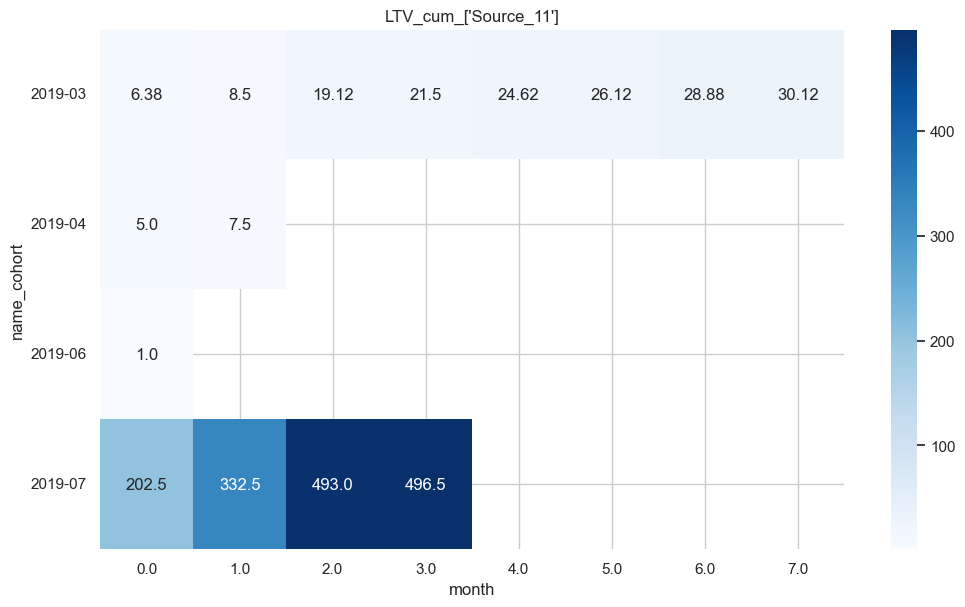

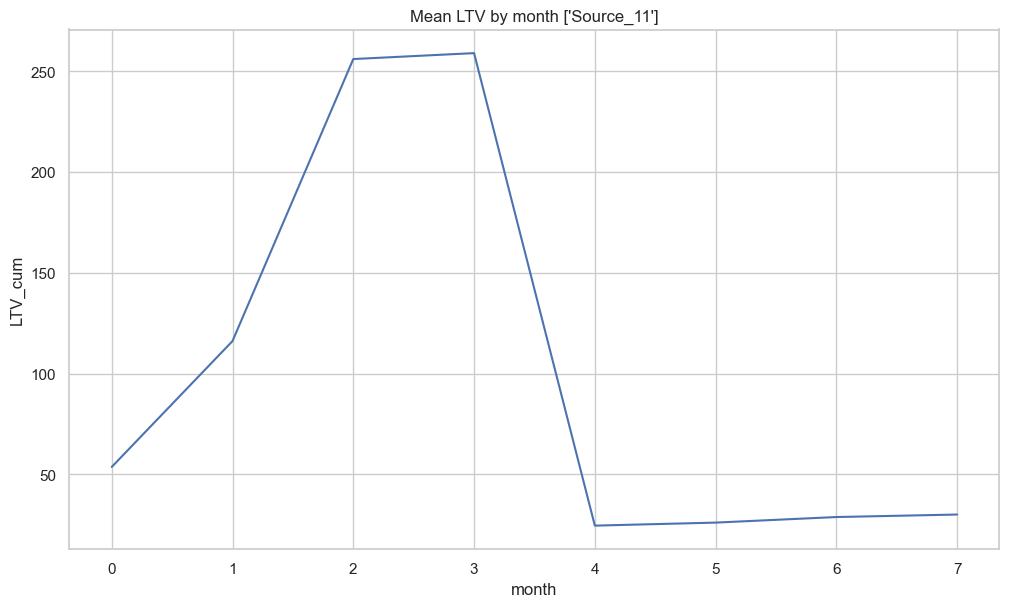

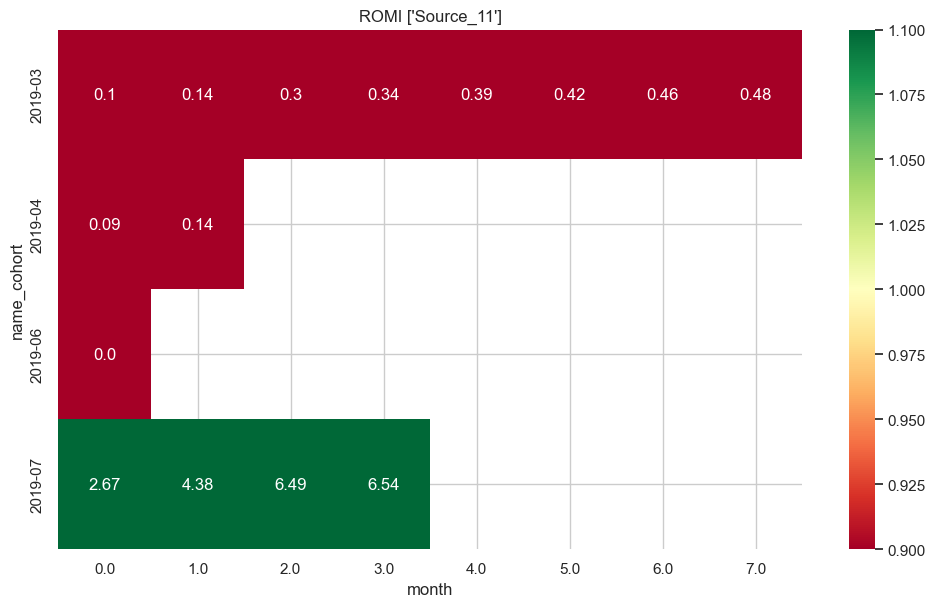

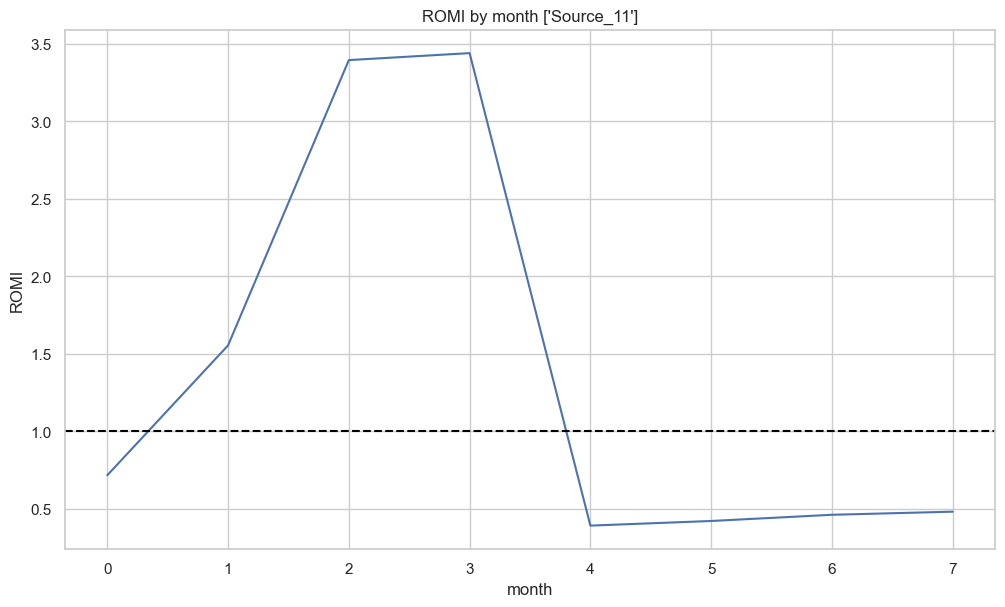

,cohort,month,Rub,size_buy_coh,revenue,size_usr_coh,cost,name_cohort,cum,LTV,LTV_cum,CAC,ROMI
0,3.0,0.0,51,8,241,83,150.71,2019-03,51,6.38,6.38,18.84,0.10
1,3.0,1.0,17,8,241,83,150.71,2019-03,68,2.12,8.50,18.84,0.14
2,3.0,2.0,85,8,241,83,150.71,2019-03,153,10.62,19.12,18.84,0.30
3,3.0,3.0,19,8,241,83,150.71,2019-03,172,2.38,21.50,18.84,0.34
4,3.0,4.0,25,8,241,83,150.71,2019-03,197,3.12,24.62,18.84,0.39


['Source_6']


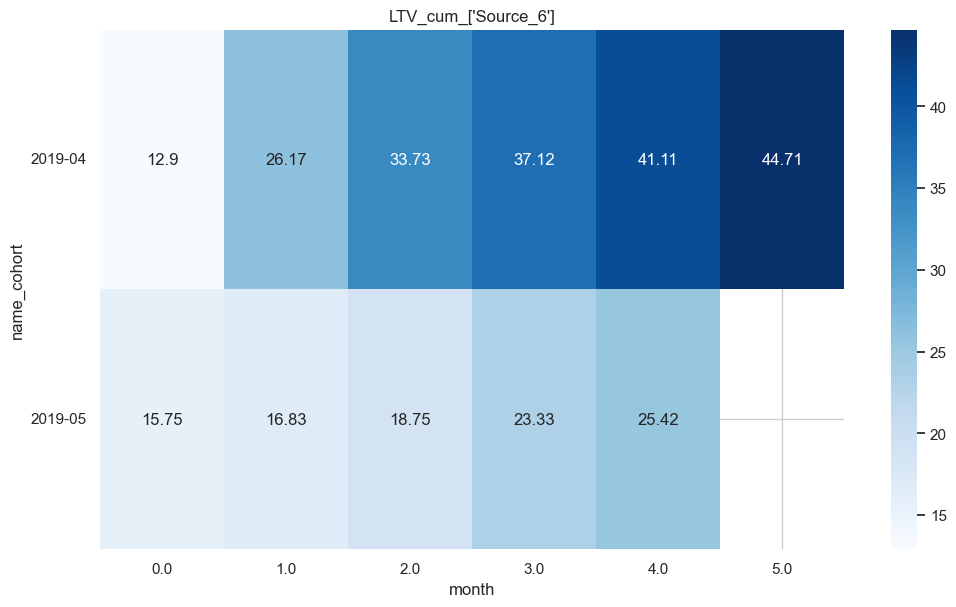

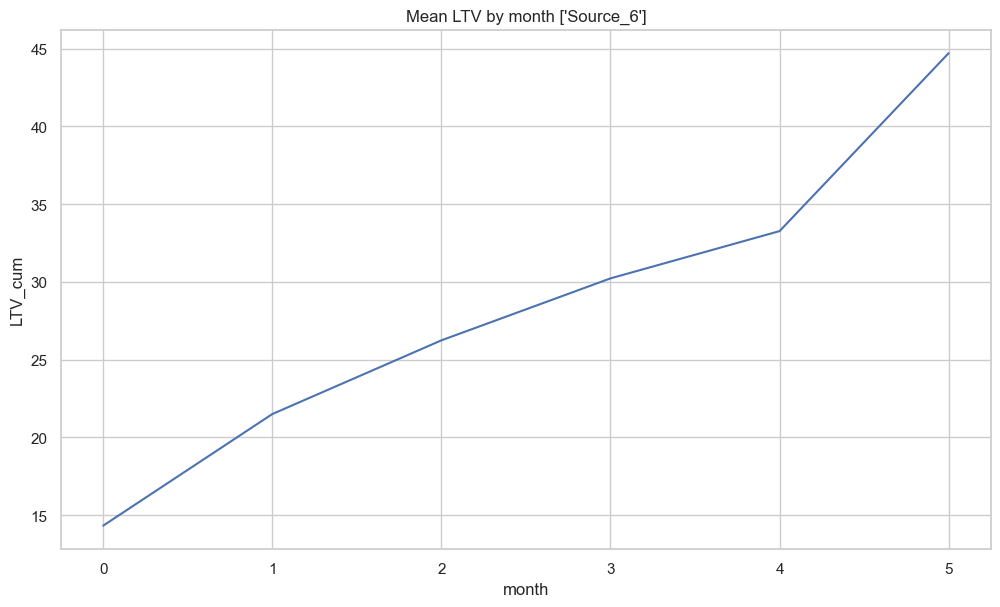

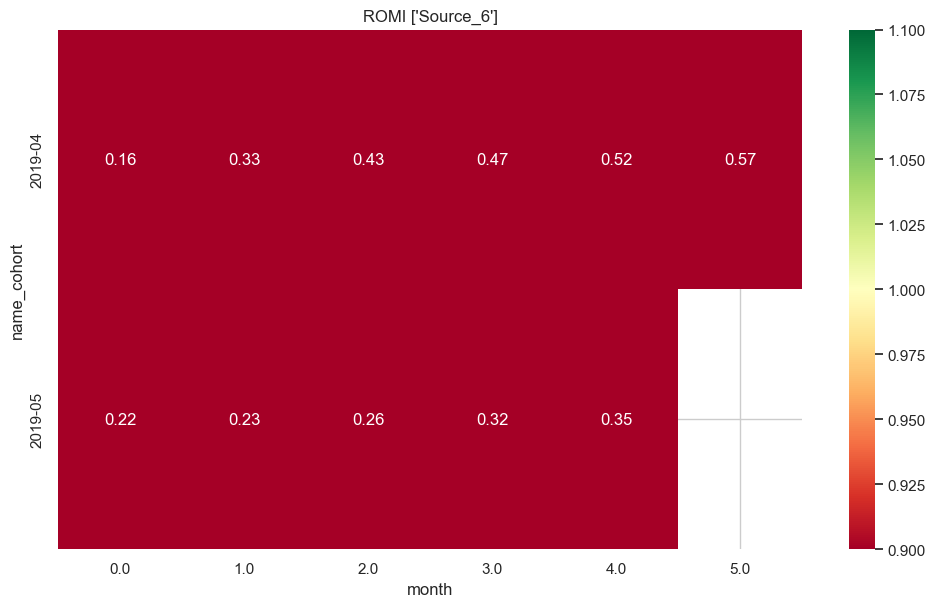

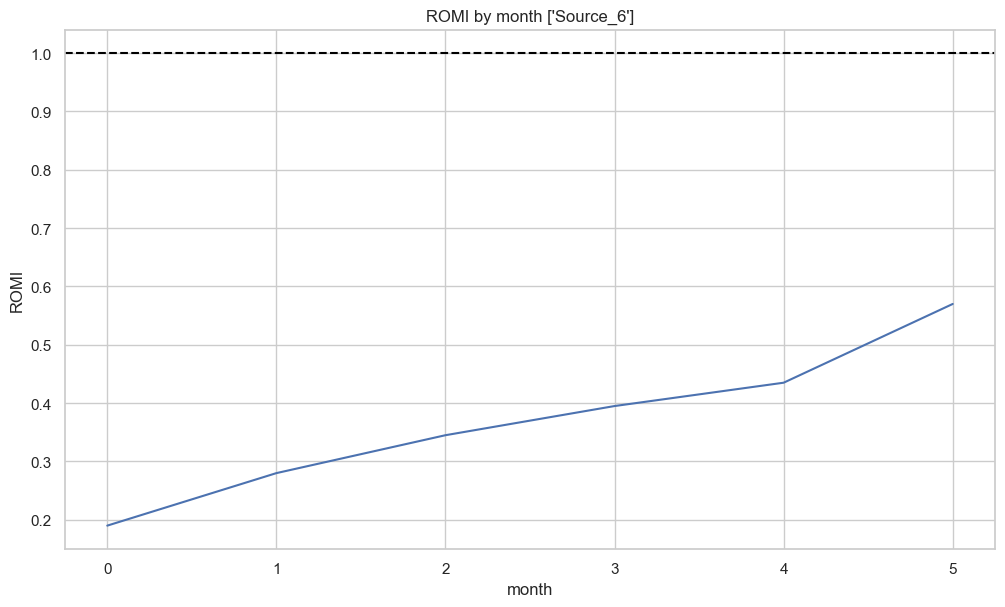

,cohort,month,Rub,size_buy_coh,revenue,size_usr_coh,cost,name_cohort,cum,LTV,LTV_cum,CAC,ROMI
0,4.0,0.0,1406,109,4873,1481,2584.28,2019-04,1406,12.90,12.90,23.71,0.16
1,4.0,1.0,1447,109,4873,1481,2584.28,2019-04,2853,13.28,26.17,23.71,0.33
2,4.0,2.0,824,109,4873,1481,2584.28,2019-04,3677,7.56,33.73,23.71,0.43
3,4.0,3.0,369,109,4873,1481,2584.28,2019-04,4046,3.39,37.12,23.71,0.47
4,4.0,4.0,435,109,4873,1481,2584.28,2019-04,4481,3.99,41.11,23.71,0.52


In [109]:
# посмотрим LTV и ROMI по каждому источнику
#name_sources = sources[(sources.cost > 0) & (sources.profitability != np.inf)] \
#    .sort_values('profitability').Source.to_list()
name_sources= ['Source_9', 'Source_14', 'Source_15', 'Source_11', 'Source_6']

for source in name_sources:
    get_by_source([source], installs, checks)

### Вывод

Канал 9 показал очень долгий период окупаемости - 11 месяцев, несмотря на то что он 1 по объёму трафика.
В перспективе стоит рассмотреть чтобы заменитьего трафик другим каналом.

Канал 14, 2-и по объёму канал, и у него хороший показатель окупаемости на 4 месяц.

Канал 15 имеет хорошие показатели, окупается на 4 месяц. На него стоит обратить внимание в первую очередь.

Канал 11 молодой, в последней когорте показал очень хорошие результаты несмотря на прошлые косяки. Перспективный.

<hr>

# Заключение

У данных хорошие показатели:
- отссутствие сильной сезонности
- нет сильных флуктуаций среднего чека в разных когортах
- хороший показатель RR на спаде около 25% от когорты
- 10 месяцев LV
- значительный рост среднего чека в когорте
- рост GM прибыли

Чувствительные показатели:  
Постепенное уменьшение аудитории из-за недостатка притока новых посетителей, порядка 30% за 10 месяцев.  
Рекомендуется увеличить рекламный трафик хотябы на 30-35% что соответствовало сохранению объёма аудитории.

Рекомендации по источникам:
пересмотреть получения трафика 9 канала из-за долгого периода окупаемости.
Увеличить 15 канал, и по возможности 14
Внимательно и осторожно поработать с каналом 11, может давать неважный трафик.
Остальные каналы показывают несостоятельность в окупаемости.


<hr>

## Дополнительно
- посчитать рекомендуемый размер расходов для отдела маркетинга по каналам
- измерить тенденции изменения цены от объема трафика по каналам
- сравнить покупателей по платформам
- проверить сомнительных пользователей
- систематизировать агрегацию и извлечение данных одной таблицей